### Курсовой проект

#### Постановка задачи:
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

##### Целевая переменная
Credit Default - факт невыполнения кредитных обязательств

##### Метрика качества
F1-score

##### Требования к решению
Целевая метрика: F1 > 0.5

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Этап 1. Предобработка тренировочных данных
- Загрузка данных
- Обзор тренировочного и тестового датасета

#### Анализ тренировочного датасета
- Анализ количественных переменных
- Анализ категориальных переменных
- Добавление новых переменных


### // Комментарии:
Исправления к VPoletaev_solution_01 (ДЗ-1):
- 'Credit Score': два варианта, первый - замена выбросов на условно плохой кредитный рейтинг, второй - деление на 10;
- 'Purpose': в тренировочном дата-сете 'renewable energy' не удаляю, добавлю соответствующую категорию в тестовом.
- 'Term': да, конечно, изначально бинарный - dummy не делаю. Просто строковые значения меняю на числовые - 0 и 1.
- Преобразовал, там где это возможно, к типу int количественные переменные.
- Добавил новый признак - 'Id' - идентификатор записи в дата-сете.

Новое в VPoletaev_solution_02_02 (ДЗ-2):
- Провел предварительный анализ (стат. исследование) категориальных и количественных признаков тренировочного дата-сета

#### Импорт модулей, библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from sklearn.metrics import f1_score

from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import boxcox
from scipy.stats import probplot

from statsmodels.graphics.gofplots import qqplot


import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.options.display.max_columns=100

#### Определение костант

In [2]:
PATH_TRAIN_DATA = 'course_project_train.csv'
PATH_TEST_DATA = 'course_project_test.csv'

#### Определение ф-ций

In [3]:
# Построение гистограммы и графика плотности распределения значений признака.
# Есть возможность установки логарифмического масштаба по оси ординат и выведения на график среднего значения,
# медианы и моды.
def plot_hist_n_kde(feature,feature_name,hist_bins=50,x_log=False,y_log=False,mmm='000'):
    rcParams['font.size'] = 8
    plt.figure(figsize=(12,5))

    plt.subplot(121)
    feature.hist(bins=hist_bins)
    plt.xlabel(feature_name)
    plt.ylabel('Кол-во записей в дата-сете')
    if y_log:
        plt.yscale('log')
    if x_log:
        plt.xscale('log')

    plt.subplot(122)
    sns.kdeplot(feature,legend=False,shade=True)
    plt.xlabel(feature_name)
    plt.ylabel('Плотность')
    if y_log:
        plt.yscale('log')
    if x_log:
        plt.xscale('log')
    
    y = np.linspace(0,plt.ylim()[1]*0.9,2)
    
    if len(mmm) == 3: 
        if int(mmm[0]):
            median_value = feature.median()
            plt.plot([median_value]*2,y,c='red',linestyle='-',label=f'медиана ({median_value:.2f})')
        if int(mmm[1]):
            mean_value = feature.mean()
            plt.plot([mean_value]*2,y,c='green',linestyle='--',label=f'среднее ({mean_value:.2f})')
        if int(mmm[2]): 
            mode_value = feature.mode()
            for i in range(len(mode_value)):
                if i == 10: break
                plt.plot([mode_value[i]]*2,y,c='orange',linestyle=':',label=f'мода ({mode_value[i]:.2f})')
            
    plt.legend(loc='upper right')

    plt.suptitle(f'Распределение значений признака "{feature_name}"',va='bottom',size=12)
    plt.show()
    
# Оценка распределения дискретного числового признака.
def plot_violin_num(data,target_feature,cat_feature,x_log=False):
    rcParams['font.size'] = 8
    plt.figure(figsize=(12,6))

    tmp_df = data[[cat_feature,target_feature]]
    tmp_df[cat_feature] = tmp_df[cat_feature].astype('category')
    
    sns.violinplot(tmp_df[target_feature],tmp_df[cat_feature])

    plt.xlabel(target_feature)
    plt.ylabel(cat_feature)
    plt.title(f'Зависимость "{cat_feature}" от "{target_feature}"')
    
    if x_log:
        plt.xscale('log')

    plt.show()
    
# Оценка распределения категориальной переменной в разрезе целевого признака 
def plot_category_distribution_by_target(df,feature,y_log=False,wide_plot=False):
    rcParams['font.size'] = 8
    if wide_plot:
        width=18
    else:
        width=12

    plt.figure(figsize=(width,5))
    
    sns.countplot(x=feature,hue='Credit Default',data=df)
    
    plt.title(f'Распределение "{feature}" в разрезе "Credit Default":')
    plt.legend(title='Целевой признак',loc='upper right')
    
    if y_log:
        plt.yscale('log')
    
    plt.show()
    
def plot_kde_n_qq(df,feature):
    """
    Оценка распределения признака feature в разрезе целевой переменной.
    """
    
    rcParams['font.size'] = 8
    plt.figure(figsize=(12,5))

    plt.subplot(121)
    sns.kdeplot(df.loc[df['Credit Default'] == 0][feature], shade=True, label='Погашен вовремя', color='g')
    sns.kdeplot(df.loc[df['Credit Default'] == 1][feature], shade=True, label='Просрочен', color='r')
        
    plt.xlabel(feature)
    plt.ylabel('Плотность')
    plt.legend(loc='upper right')
    
    plt.subplot(122)
    probplot(df[feature].sample(1000),plot=plt)

    plt.suptitle(f'Распределение значений признака "{feature}" в разрезе целевой переменной',va='bottom',size=12)
    plt.show() 
    
def plot_kde_n_qq_tt(df_train,df_test,feature):
    """
    Оценка распределения признака feature из тренировочной и тестовой выборок.
    """
    
    rcParams['font.size'] = 8
    plt.figure(figsize=(12,5))

    plt.subplot(121)
    sns.kdeplot(df_train[feature], shade=True, label='Train', color='orange')
    sns.kdeplot(df_test[feature], shade=True, label='Test', color='blue')
        
    plt.xlabel(feature)
    plt.ylabel('Плотность')
    plt.legend(loc='upper right')
    
    plt.subplot(122)
    probplot(df_test[feature].sample(1000),plot=plt)
    plt.title('Тестовый дата-сет')

    plt.suptitle(f'Распределение значений признака "{feature}" в тренировочном и тестовом дата-сетах',va='bottom',size=12)
    plt.show() 
    
def plot_confidence_interval_by_target(df,feature):
    """
    Построение доверительных интервалов для признака feature в разрезе целевой переменной.
    """
    
    rcParams['font.size'] = 8
    plt.figure(figsize=(8,4))
    
    sns.pointplot(x='Credit Default', y=feature, data=df[[feature,'Credit Default']], capsize=.1)

    plt.title(f'Доверительные интервалы (95 %) для признака "{feature}"')
    plt.show()
    
def plot_q_q(feature,sample_power=1000):
    """
    Построение Q-Q диаграммы.
    """
    
    rcParams['font.size'] = 8
    plt.figure(figsize=(8,4))
    
    qqplot(feature.sample(sample_power), line='s')
    plt.show()
    
# Получение статистики по числовому признаку.
def statistics_on_feature(data,feature_groupby,feature_stat):
    return data.groupby(feature_groupby).agg({feature_stat:['mean','median','min','max','count']})

# Заполнение пропусков в 'Annual Income' медианными значениями в зависимости от цели кредита
def fill_annual_income_nan(df):
    columns = df['Purpose'].value_counts().index.to_list()
    median_common = df['Annual Income'].median()
    for col in columns:
        median_by_purpose = df.loc[df['Purpose']==col, 'Annual Income'].median()
        if np.isnan(median_by_purpose):
            df.loc[df['Annual Income'].isnull() & (df['Purpose']==col),'Annual Income'] = median_common
        else:
             df.loc[df['Annual Income'].isnull() & (df['Purpose']==col),'Annual Income'] = median_by_purpose
                
# Обработка выбросов в 'Credit Default'. Вариант-1.
def fill_credit_score_nan_n_anomalies_1(df,bad_rating):
    """
    Все пропуски меняем:
    - при 'Credit Score' равном 0, на медиану;
    - при 'Credit Score' равном 1, на bad_rating (условно плохой кредитный рейтинг);

    Аномально большие значения заменим также на bad_rating, т.к., судя по графику, 
    аномальные значения присутствуют только в дефолтных записях.
    """
    median_normal =  df.loc[df['Credit Default'] == 0,'Credit Score'].median()
    df.loc[df['Credit Score'].isnull() & (df['Credit Default'] == 0),'Credit Score'] = median_normal
    df.loc[df['Credit Score'].isnull() & (df['Credit Default'] == 1),'Credit Score'] = bad_rating
    df.loc[df['Credit Score'] > 1000,'Credit Score'] = bad_rating

# Обработка выбросов в 'Credit Default'. Вариант-2.
def fill_credit_score_nan_n_anomalies_2(df,bad_rating):
    """
    Все пропуски меняем:
    - при 'Credit Score' равном 0, на медиану;
    - при 'Credit Score' равном 1, на bad_rating (условно плохой кредитный рейтинг);
    
    Аномально высокие значения (больше 1000) разделим на 10, исходя из предположения, что эти значения являются
    ошибками ввода с лишним нулем на конце.
    """
    median_normal =  df.loc[df['Credit Default'] == 0,'Credit Score'].median()
    df.loc[df['Credit Score'].isnull() & (df['Credit Default'] == 0),'Credit Score'] = median_normal
    df.loc[df['Credit Score'].isnull() & (df['Credit Default'] == 1),'Credit Score'] = bad_rating
    df.loc[df['Credit Score'] > 1000,'Credit Score'] = df.loc[df['Credit Score'] > 1000,'Credit Score']/10
    
def fill_credit_score_nan_n_anomalies_2_test_df(df):
    """
    Для тестового дата-сета.
    
    Все пропуски меняем на медиану.
    
    Аномально высокие значения (больше 1000) разделим на 10, исходя из предположения, что эти значения являются
    ошибками ввода с лишним нулем на конце.
    """
    median_normal =  df.loc[df['Credit Score'] < 1000,'Credit Score'].median()
    df.loc[df['Credit Score'].isnull(),'Credit Score'] = median_normal
    df.loc[df['Credit Score'] > 1000,'Credit Score'] = df.loc[df['Credit Score'] > 1000,'Credit Score']/10

def chi2_mean(df,feature,cat_1,cat_2,iter_num,sample_power):
    """
    Вычисление среднего хи-квадрат из iter_num сэмплов мощностью sample_power каждый.
    """
            
    chi2_list = []
            
    for i in range(iter_num):
        
        values_sum = df.loc[df[feature] == cat_1,feature].count() + df.loc[df[feature] == cat_2,feature].count()
        iter_sample_power = values_sum if values_sum < sample_power else sample_power
        
        sample = df.loc[df[feature].isin([cat_1,cat_2]),['Id',feature,'Credit Default']].sample(iter_sample_power)
        table = sample.pivot_table(values='Id',index=feature,columns='Credit Default',aggfunc='count')
        chi2, p, dof, expected = chi2_contingency(table,correction=False)
                
        if not np.isnan(chi2):
            chi2_list.append(chi2)
                    
    chi2_list_len = len(chi2_list)            
    if chi2_list_len:            
        chi2_mean = sum(chi2_list)/chi2_list_len
    else:
        chi2_mean = None
            
    print(f'\tСреднее хи-квадрат: {chi2_mean} \n\tКол-во ненулевых сэмплов: {chi2_list_len} из {iter_num}')
    print(f'\tМощность сэмпла: {iter_sample_power}')

def chi2_mean_all_to_all(df,feature,iter_num,sample_power):
    """
    Вычисление среднего хи-квадрат из iter_num сэмплов мощностью sample_power каждый для каждой пары значений
    признака.
    """
    
    cats_1 = df[feature].unique().tolist()
    cats_2 = cats_1[:]
    
    for cat_1 in cats_1:
        for cat_2 in cats_2:
            if cat_1 != cat_2:
                print(f'\n"{cat_1}" --- "{cat_2}":')
                chi2_mean(df,feature,cat_1,cat_2,iter_num,sample_power)
        
        cats_2.remove(cat_1)
    
def shapiro_mean(feature,iter_num,sample_power,bc=True):
    """
    Вычисление среднего p-value по критерию Шапиро-Уилка из iter_num сэмплов мощностью sample_power каждый.
    """
            
    p_list = []
    p_list_boxcox = []
    p_list_log = []
            
    for i in range(iter_num):        
        sample = feature.sample(sample_power)
        
        s, p = shapiro(sample)
        p_list.append(p)
        
        if bc:
            sample_boxcox, maxlog = boxcox(sample)
            s, p = shapiro(sample_boxcox)
            p_list_boxcox.append(p)
        
        sample_log = np.log(sample)/np.log(2)
        s, p = shapiro(sample_log)
        p_list_log.append(p)
             
#     p_list_len =  len(p_list)       
#     if p_list_len:            
#         p_mean = sum(p_list)/p_list_len
#     else:
#         p_mean = None
        
#     p_list_boxcox_len =  len(p_list_boxcox)       
#     if p_list_boxcox_len:            
#         p_mean_boxcox = sum(p_list_boxcox)/p_list_boxcox_len
#     else:
#         p_mean_boxcox = None
        
#     p_list_log_len =  len(p_list_log)       
#     if p_list_log_len:            
#         p_mean_log = sum(p_list_log)/p_list_log_len
#     else:
#         p_mean_log = None
        
    p_mean = sum(p_list)/len(p_list)
    if bc:
        p_mean_boxcox = sum(p_list_boxcox)/len(p_list_boxcox)
    p_mean_log = sum(p_list_log)/len(p_list_log)
            
    print(f'Среднее p-value (original): {p_mean}')
    if bc:
        print(f'Среднее p-value (boxcox)  : {p_mean_boxcox}')
    print(f'Среднее p-value (log)     : {p_mean_log}')
    print(f'Кол-во сэмплов: {iter_num}, мощность каждого сэмпла: {sample_power}')
    
def mannwhitney_mean(df,feature,iter_num,sample_power):
    """
    Вычисление среднего p-value по критерию Манна-Уитни из iter_num сэмплов мощностью sample_power каждый.
    """
    
    df_feature = df[[feature,'Credit Default']]
            
    p_list = []
            
    for i in range(iter_num):        
        sample = df_feature.sample(sample_power)
        
        sample_0 = sample[sample['Credit Default']==0][feature]
        sample_1 = sample[sample['Credit Default']==1][feature]
        
        s, p = mannwhitneyu(sample_0,sample_1)

        p_list.append(p)
             
    p_list_len =  len(p_list)       
    if p_list_len:            
        p_mean = sum(p_list)/p_list_len
    else:
        p_mean = None
            
    print(f'Среднее p-value: {p_mean}')
    print(f'Кол-во сэмплов: {iter_num}, мощность каждого сэмпла: {sample_power}')
    
def t_test_mean(df,feature,iter_num,sample_power):
    """
    Вычисление среднего p-value по критерию Стьюдента из iter_num сэмплов мощностью sample_power каждый.
    """
    
    df_feature = df[[feature,'Credit Default']]
            
    p_list = []
            
    for i in range(iter_num):        
        sample = df_feature.sample(sample_power)
        
        sample_0 = sample[sample['Credit Default']==0][feature]
        sample_1 = sample[sample['Credit Default']==1][feature]
        
        s, p = ttest_ind(sample_0,sample_1)

        p_list.append(p)
             
    p_list_len =  len(p_list)       
    if p_list_len:            
        p_mean = sum(p_list)/p_list_len
    else:
        p_mean = None
            
    print(f'Среднее p-value: {p_mean}')
    print(f'Кол-во сэмплов: {iter_num}, мощность каждого сэмпла: {sample_power}')
    
def mannwhitney_mean_t_t(df_train,df_test,feature,iter_num,sample_power):
    """
    Вычисление среднего p-value по критерию Манна-Уитни из iter_num сэмплов мощностью sample_power каждый.
    Сравниваются сэмплы из тренировочного и тестового дата-сета.
    """
            
    p_list = []
            
    for i in range(iter_num):        
        sample_train = df_train[feature].sample(sample_power)
        sample_test = df_test[feature].sample(sample_power)
        
        s, p = mannwhitneyu(sample_train,sample_test)

        p_list.append(p)
             
    p_list_len =  len(p_list)       
    if p_list_len:            
        p_mean = sum(p_list)/p_list_len
    else:
        p_mean = None
            
    print(f'Среднее p-value: {p_mean}')
    print(f'Кол-во сэмплов: {iter_num}, мощность каждого сэмпла: {sample_power}')

## Этап 1. Предобработка тренировочных данных

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Тренировочный датасет:

In [4]:
df_train = pd.read_csv(PATH_TRAIN_DATA)

In [5]:
df_train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [6]:
df_train.shape

(7500, 17)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

##### В тренировочном дата-сете следующие столбцы имеют пропущенные значения:
* Annual Income
* Years in current job
* Months since last delinquent
* Bankruptcies
* Credit Score

In [8]:
df_train.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

#### Тестовый датасет:

In [9]:
df_test = pd.read_csv(PATH_TEST_DATA)

In [10]:
df_test.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

In [11]:
df_test.shape

(2500, 16)

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

##### В тестовом дата-сете следующие столбцы имеют пропущенные значения:
* Annual Income
* Years in current job
* Months since last delinquent
* Bankruptcies
* Credit Score

Всё те же признаки, что и в тренировочных данных.

In [13]:
df_test.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   1.987000e+03  2500.000000              2500.000000   
mean    1.366922e+06     0.035200                11.184400   
std     9.171252e+05     0.386291                 4.852774   
min     1.065330e+05     0.000000                 1.000000   
25%     8.523115e+05     0.000000                 8.000000   
50%     1.178475e+06     0.000000                10.000000   
75%     1.629734e+06     0.000000                14.000000   
max     1.497561e+07    15.000000                48.000000   

       Years of Credit History  Maximum Open Credit  \
count              2500.000000         2.500000e+03   
mean                 18.325920         7.105704e+05   
std                   7.254659         1.511983e+06   
min                   3.900000         0.000000e+00   
25%                  13.400000         2.785860e+05   
50%                  17.000000         4.786760e+05   
75%                  22.100000         8.025985e+05   
max                  53.400000         5.448439e+07   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                2500.000000                   1142.000000   2497.000000   
mean                    0.162000                     34.181261      0.106928   
std                     0.559894                     22.024277      0.357189   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     30.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                    15.000000                     82.000000      5.000000   

       Current Loan Amount  Current Credit Balance  Monthly Debt  Credit Score  
count         2.500000e+03            2.500000e+03   2500.000000   1987.000000  
mean          1.215572e+07            2.963966e+05  18271.340000   1234.516860  
std           3.226097e+07            3.783020e+05  11543.881469   1740.219442  
min           1.542200e+04            0.000000e+00     93.000000    585.000000  
25%           1.871265e+05            1.101145e+05  10024.750000    710.000000  
50%           3.223660e+05            2.073850e+05  16642.500000    731.000000  
75%           5.225825e+05            3.663485e+05  24146.000000    743.000000  
max           1.000000e+08            6.030087e+06  93555.000000   7480.000000

### Анализ тренировочного датасета

In [14]:
df_train_prep_01 = df_train.copy()

### *Анализ количественных переменных*

#### 1. Проверка, корректировка "Annual Income"

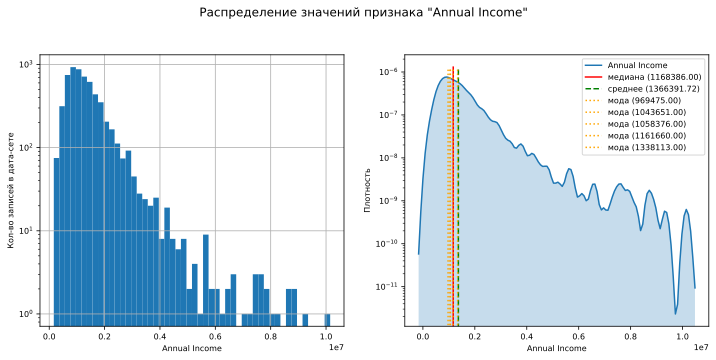

In [15]:
plot_hist_n_kde(df_train_prep_01['Annual Income'], 'Annual Income', y_log=True, mmm='111')

In [16]:
print(f"Минимальное значение: {df_train_prep_01['Annual Income'].min()}")
print(f"Максимальное значение: {df_train_prep_01['Annual Income'].max()}")

Минимальное значение: 164597.0
Максимальное значение: 10149344.0


На основании графиков можно сделать вывод, что, возможно, значения годового дохода в р-не 10 млн. являются аномальными. Зачем людям с таким годовым доходом кредитоваться? Посмотрим на цели кредитов:

In [17]:
df_train_prep_01.loc[df_train_prep_01['Annual Income'] > 9000000, 'Purpose']

2200         business loan
6472    debt consolidation
Name: Purpose, dtype: object

Цели кредитов - бизнес и, насколько понимаю, реструктуризация долгов. Т.е. это не бытовые нужды. Что, считаю, вполне логично для состоятельных заемщиков. Поэтому данные высокие значения годового дохода выбросами не считаю.

##### Обработка пропусков:

Кол-во пропущенных значений 'Annual Income' по целям кредита:

In [18]:
df_train_prep_01.loc[df_train_prep_01['Annual Income'].isnull(), 'Purpose'].value_counts()

debt consolidation      1214
other                    148
home improvements         96
business loan             23
buy a car                 19
medical bills             13
major purchase            10
take a trip               10
buy house                  8
small business             6
wedding                    3
vacation                   3
renewable energy           2
moving                     1
educational expenses       1
Name: Purpose, dtype: int64

Статистика по 'Annual Income' в зависимости от цели кредита:

In [19]:
statistics_on_feature(df_train_prep_01, 'Purpose', 'Annual Income')

Annual Income                                       
                              mean     median       min         max count
Purpose                                                                  
business loan         1.578203e+06  1254893.0  206017.0   9338880.0   106
buy a car             1.271642e+06   937137.0  226765.0   4473816.0    77
buy house             1.757871e+06  1314505.5  467039.0   7381842.0    26
debt consolidation    1.346966e+06  1165878.0  164597.0  10149344.0  4730
educational expenses  1.179417e+06   569943.0  201381.0   3752880.0     9
home improvements     1.640379e+06  1350301.5  233453.0   8758449.0   316
major purchase        1.347141e+06  1360466.5  244682.0   3793179.0    30
medical bills         1.601686e+06  1339443.0  191577.0   7660648.0    58
moving                1.012979e+06   775865.0  596163.0   2293908.0    10
other                 1.306160e+06  1133046.0  192223.0   6492395.0   517
renewable energy               NaN        NaN       NaN         NaN     0
small business        1.326634e+06  1081765.0  290415.0   4772800.0    20
take a trip           1.153258e+06   980685.0  199690.0   4667616.0    27
vacation              1.578060e+06  2013734.0  598576.0   2400631.0     5
wedding               2.095394e+06  1330693.5  730835.0   6620208.0    12

Для заполнения пропусков буду брать медианные значения, в зависимости от целей кредита:

In [20]:
fill_annual_income_nan(df_train_prep_01)

In [21]:
statistics_on_feature(df_train_prep_01, 'Purpose', 'Annual Income')

Annual Income                                        
                              mean     median        min         max count
Purpose                                                                   
business loan         1.520559e+06  1254893.0   206017.0   9338880.0   129
buy a car             1.205438e+06   937137.0   226765.0   4473816.0    96
buy house             1.653550e+06  1314505.5   467039.0   7381842.0    34
debt consolidation    1.309981e+06  1165878.0   164597.0  10149344.0  5944
educational expenses  1.118469e+06   569943.0   201381.0   3752880.0    10
home improvements     1.572788e+06  1350301.5   233453.0   8758449.0   412
major purchase        1.350472e+06  1360466.5   244682.0   3793179.0    40
medical bills         1.553670e+06  1339443.0   191577.0   7660648.0    71
moving                9.914235e+05   775865.0   596163.0   2293908.0    11
other                 1.267632e+06  1133046.0   192223.0   6492395.0   665
renewable energy      1.168386e+06  1168386.0  1168386.0   1168386.0     2
small business        1.270126e+06  1081765.0   290415.0   4772800.0    26
take a trip           1.106617e+06   980685.0   199690.0   4667616.0    37
vacation              1.741438e+06  2013734.0   598576.0   2400631.0     8
wedding               1.942454e+06  1330693.5   730835.0   6620208.0    15

Проверка - не осталось ли пропущенных значений:

In [22]:
len(df_train_prep_01.loc[df_train_prep_01['Annual Income'].isnull()])

0

Зависит ли вероятность дефолта по кредиту от годового дохода заемщика? Построим график:

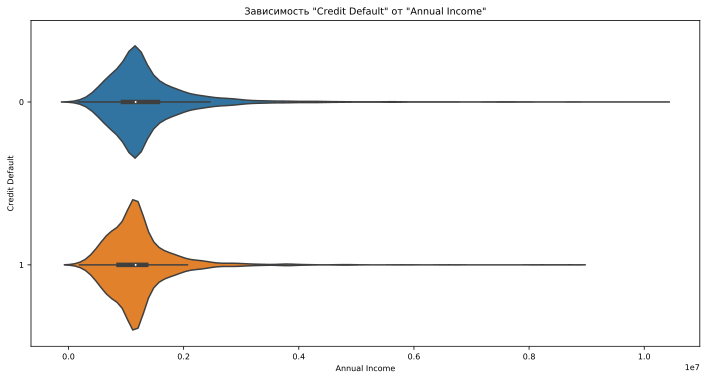

In [23]:
plot_violin_num(df_train_prep_01,'Annual Income','Credit Default')

Судя по графику, риску дефолта подвергнуты все категории заемщиков - вне зависимости от годового дохода.

#### 2. Проверка, корректировка "Tax Liens"

Так понимаю, это кол-во задолженностей по налогам.

In [24]:
df_train_prep_01['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [25]:
df_test['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

Кол-во вариантов значений данного признака в тренировочном и в тестовом дата-сетах невелико, но переводить данный признак в категориальный считаю неправильным. Аномальных значений нет. Оставляю все как есть.

#### 3. Проверка, корректировка "Number of Open Accounts"

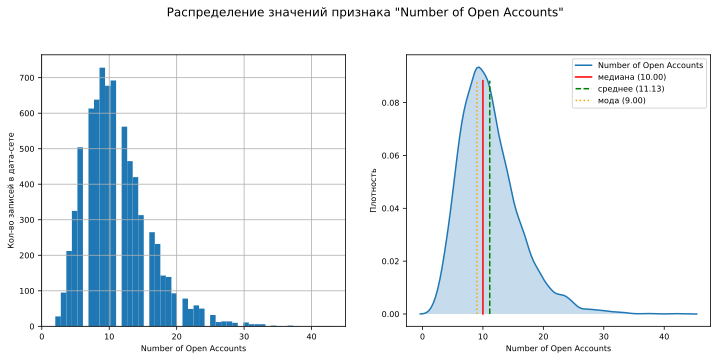

In [26]:
plot_hist_n_kde(df_train_prep_01['Number of Open Accounts'], 'Number of Open Accounts', mmm='111')

In [27]:
df_train_prep_01['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

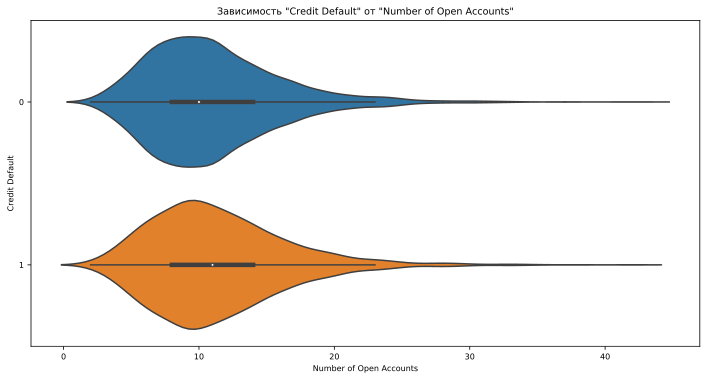

In [28]:
plot_violin_num(df_train_prep_01,'Number of Open Accounts','Credit Default')

Аномалий в значениях данного признака нет.

#### 4. Проверка, корректировка "Years of Credit History"

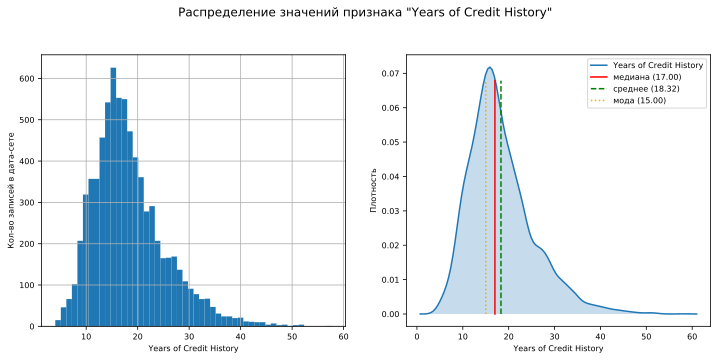

In [29]:
plot_hist_n_kde(df_train_prep_01['Years of Credit History'], 'Years of Credit History', mmm='111')

In [30]:
df_train_prep_01['Years of Credit History'].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64

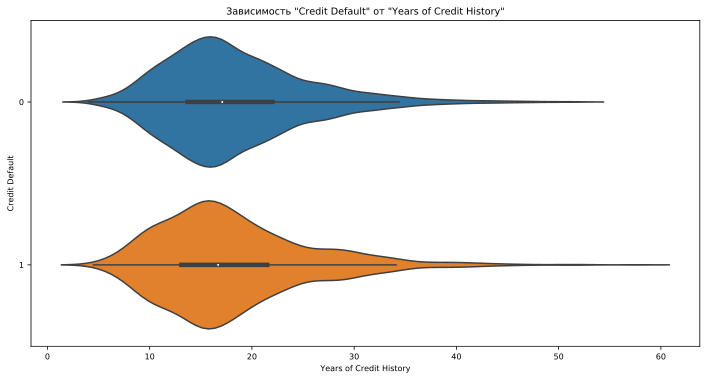

In [31]:
plot_violin_num(df_train_prep_01,'Years of Credit History','Credit Default')

Аномалий не видно. Риску дефолта подвержены заемщики с различной по длительности кредитной историей.

#### 5. Проверка, корректировка "Current Loan Amount"

Нарушу порядок анализа признаков - "очищенные" значения текущей суммы кредита понадобятся для обработки 'Maximum Open Credit'.

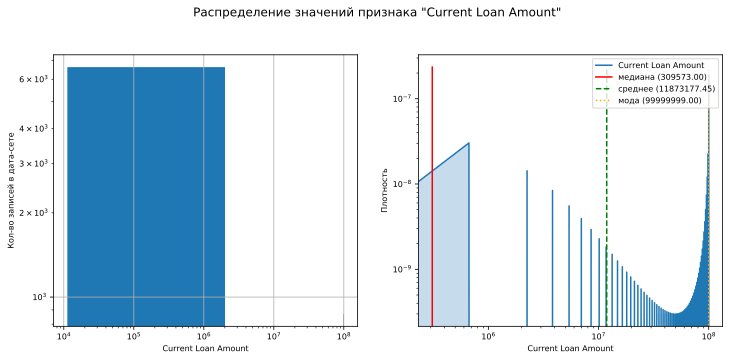

In [32]:
plot_hist_n_kde(df_train_prep_01['Current Loan Amount'], 'Current Loan Amount', x_log=True, y_log=True, mmm='111')

In [33]:
df_train_prep_01['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [34]:
df_train_prep_01['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

Максимальное значение, не считая 99999999:

In [35]:
df_train_prep_01.loc[df_train_prep_01['Current Loan Amount'] < 99999999,'Current Loan Amount'].max()

789030.0

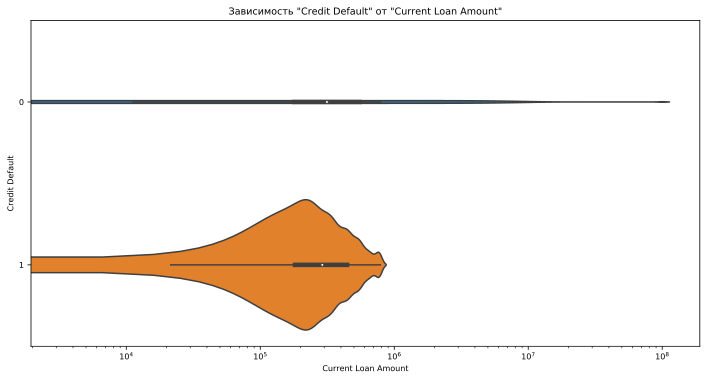

In [36]:
plot_violin_num(df_train_prep_01,'Current Loan Amount','Credit Default',x_log=True)

In [37]:
df_train_prep_01.loc[(df_train_prep_01['Current Loan Amount'] == 99999999)&(df_train_prep_01['Credit Default'] == 0),'Current Loan Amount'].count()

870

Значения 'Current Loan Amount', равные моде, определенно являются выбросами. Их почти 12% от общего числа значений. К тому же они на два порядка больше, чем предыдущее максимальное значение.

Заменю эти аномальные значения на медианное, полученное без учета этих выбросов. К тому же все аномальные значения 'Current Loan Amount' находятся только в тех записях дата-сета, значение целевого признака которых равно нулю (т.е. не дефолтные записи). Поэтому, предполагаю, замена выбросов на медианное значение не ухудшит модель классификации.

Но, как вариант, можно использовать медианные значения, полученные в зависимости от срока кредита, текущего кредитного баланса или годового дохода.

In [38]:
median_normal = df_train_prep_01.loc[df_train_prep_01['Current Loan Amount'] < 99999999,'Current Loan Amount'].median()
median_normal

265826.0

In [39]:
df_train_prep_01.loc[df_train_prep_01['Current Loan Amount'] == 99999999,'Current Loan Amount'] = median_normal

Посмотрим, что получилось:

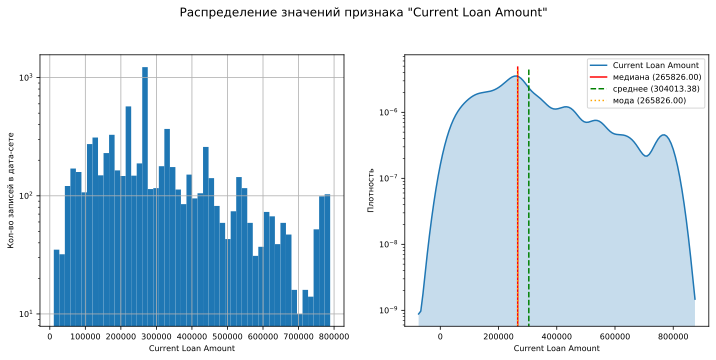

In [40]:
plot_hist_n_kde(df_train_prep_01['Current Loan Amount'], 'Current Loan Amount', y_log=True, mmm='111')

In [41]:
df_train_prep_01['Current Loan Amount'].describe()

count      7500.000000
mean     304013.377067
std      171951.057747
min       11242.000000
25%      180169.000000
50%      265826.000000
75%      396929.500000
max      789030.000000
Name: Current Loan Amount, dtype: float64

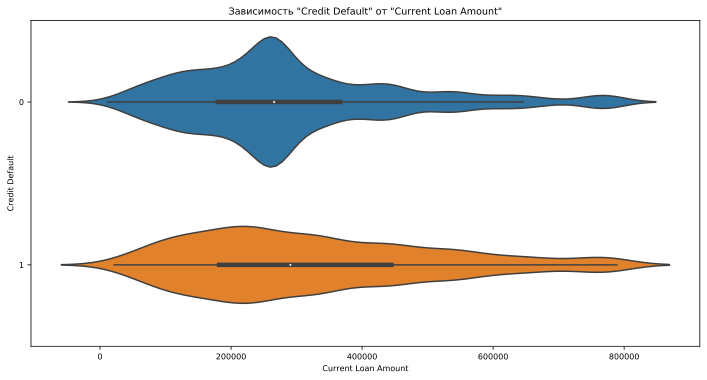

In [42]:
plot_violin_num(df_train_prep_01,'Current Loan Amount','Credit Default')

#### 6. Проверка, корректировка "Maximum Open Credit"

Так понимаю, это максимальный по сумме открытый кредит за все время кредитной истории.

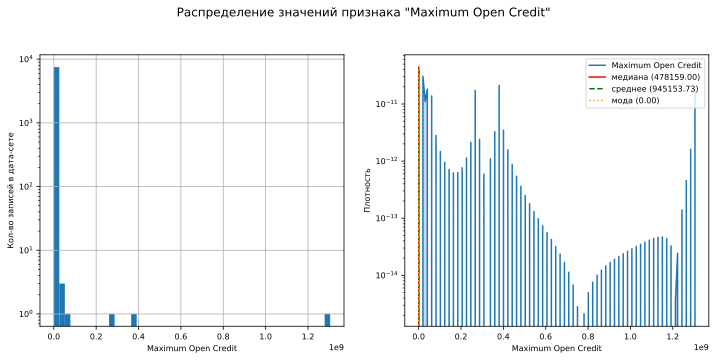

In [43]:
plot_hist_n_kde(df_train_prep_01['Maximum Open Credit'], 'Maximum Open Credit', y_log=True, mmm='111')

In [44]:
df_train_prep_01['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [45]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] == 0,'Maximum Open Credit'].count()

65

65 записей в датасете имеют значением данного признака 0. Может ли макисмальная сумма взятого кредита равняться нулю? Вряд ли. Посмотрим на текущую задолженность этих заемщиков:

In [46]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] == 0,'Current Loan Amount'].describe()

count        65.000000
mean     261298.400000
std      190367.188212
min       11242.000000
25%      112728.000000
50%      244684.000000
75%      301048.000000
max      760452.000000
Name: Current Loan Amount, dtype: float64

Ноль - это явно аномальное значение. Исправлю - сделаю равным текущей сумме кредита:

In [47]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] == 0,'Maximum Open Credit'] = df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] == 0,'Current Loan Amount']

Также есть аномально высокие значения:

In [48]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] > (10**7)]

Home Ownership  Annual Income Years in current job  Tax Liens  \
44    Have Mortgage      1334256.0            10+ years        0.0   
354   Home Mortgage      2126537.0            10+ years        0.0   
617   Home Mortgage      1165878.0              3 years        0.0   
1476       Own Home      1165878.0              8 years        0.0   
1879  Home Mortgage      1433835.0              6 years        0.0   
2023           Rent      1342825.0            10+ years        0.0   
2468  Home Mortgage      5589420.0              4 years        0.0   
2617  Home Mortgage      3217802.0            10+ years        0.0   
2763  Home Mortgage      3377440.0            10+ years        0.0   
3170  Home Mortgage      2226230.0            10+ years        0.0   
4072  Home Mortgage      2598345.0              8 years        0.0   
4745       Own Home      6029954.0              4 years        0.0   
4769  Home Mortgage      3739960.0              9 years        0.0   
4840  Home Mortgage      1687599.0              5 years        0.0   
5523  Home Mortgage      1520304.0            10+ years        0.0   
5731  Home Mortgage      1475198.0              8 years        0.0   
5950  Home Mortgage      1921660.0            10+ years        0.0   
6744  Home Mortgage      2390675.0             < 1 year        0.0   
7026  Home Mortgage      3312365.0              5 years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
44                       17.0                     15.4         3.800523e+08   
354                      23.0                     23.0         1.476048e+07   
617                      13.0                     27.5         1.304726e+09   
1476                     14.0                     28.9         1.042866e+07   
1879                      8.0                     17.8         1.270144e+07   
2023                     12.0                     16.3         5.756256e+07   
2468                     11.0                     12.3         1.634591e+07   
2617                     12.0                     35.5         2.655129e+08   
2763                     11.0                     23.2         4.092389e+07   
3170                     20.0                     19.0         1.868381e+07   
4072                      9.0                     20.7         1.389707e+07   
4745                     30.0                     17.5         1.160386e+07   
4769                      7.0                     22.8         2.634333e+07   
4840                     17.0                     17.1         1.020160e+07   
5523                     21.0                     35.5         2.137243e+07   
5731                     10.0                     24.9         1.928043e+07   
5950                     13.0                     21.0         1.151346e+07   
6744                     15.0                     20.1         1.030907e+07   
7026                     13.0                     25.3         2.640700e+07   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
44                          1.0                          35.0           0.0   
354                         0.0                           NaN           0.0   
617                         0.0                           NaN           0.0   
1476                        0.0                           NaN           0.0   
1879                        0.0                          35.0           0.0   
2023                        0.0                           NaN           0.0   
2468                        0.0                          24.0           0.0   
2617                        0.0                           NaN           0.0   
2763                        0.0                          59.0           0.0   
3170                        0.0                           NaN           0.0   
4072                        0.0                           NaN           0.0   
4745                        0.0                           NaN           0.0

Заменю их на соответствующие значения кредитного баланса:

In [49]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] > (10**7),'Maximum Open Credit'] = df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] > (10**7),'Current Credit Balance']

Посмотрим, что получилось:

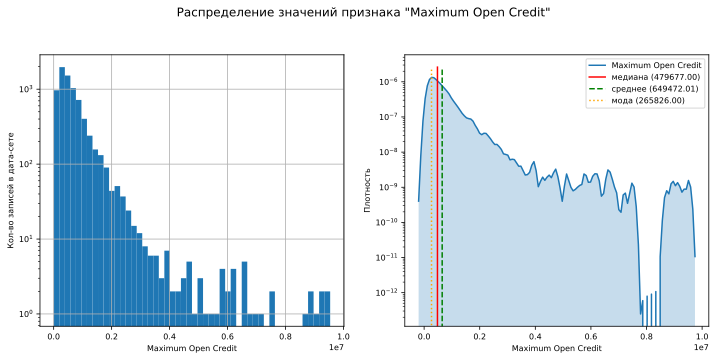

In [50]:
plot_hist_n_kde(df_train_prep_01['Maximum Open Credit'], 'Maximum Open Credit', y_log=True, mmm='111')

In [51]:
df_train_prep_01['Maximum Open Credit'].describe()

count    7.500000e+03
mean     6.494720e+05
std      6.799492e+05
min      4.334000e+03
25%      2.812150e+05
50%      4.796770e+05
75%      7.934300e+05
max      9.541136e+06
Name: Maximum Open Credit, dtype: float64

Возможно, все значения 'Maximum Open Credit' больше 8 млн. являются выбросами. Там их не так много осталось (см. ниже). Но оставлю пока так.

In [52]:
df_train_prep_01.loc[df_train_prep_01['Maximum Open Credit'] > (0.8*10**7)]

Home Ownership  Annual Income Years in current job  Tax Liens  \
85    Home Mortgage      1301614.0              9 years        0.0   
2036  Home Mortgage      1172984.0              4 years        0.0   
2156  Home Mortgage      4044112.0            10+ years        0.0   
2431       Own Home      1283279.0                  NaN        0.0   
4602  Home Mortgage      3990038.0            10+ years        0.0   
5147  Home Mortgage      1432277.0            10+ years        0.0   
5974  Home Mortgage      3131865.0            10+ years        0.0   
6265  Home Mortgage      1350301.5            10+ years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
85                       17.0                     18.0            9339924.0   
2036                      6.0                     24.2            9094184.0   
2156                     22.0                     26.5            8706038.0   
2431                     17.0                     31.4            8947840.0   
4602                     10.0                     23.0            9541136.0   
5147                      6.0                     29.2            9516540.0   
5974                      8.0                     24.8            8903180.0   
6265                     13.0                     22.8            9167356.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
85                          0.0                           NaN           0.0   
2036                        0.0                           NaN           0.0   
2156                        0.0                           NaN           0.0   
2431                        0.0                          26.0           0.0   
4602                        0.0                           5.0           0.0   
5147                        0.0                           NaN           0.0   
5974                        0.0                           NaN           0.0   
6265                        0.0                          41.0           0.0   

                 Purpose        Term  Current Loan Amount  \
85    debt consolidation  Short Term             592240.0   
2036       business loan   Long Term             335324.0   
2156   home improvements  Short Term             265826.0   
2431  debt consolidation  Short Term             350350.0   
4602   home improvements   Long Term             788788.0   
5147   home improvements  Short Term             265826.0   
5974  debt consolidation   Long Term             559636.0   
6265   home improvements  Short Term             769384.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
85                  959899.0       16813.0         748.0               0  
2036               1413733.0        8709.0         748.0               0  
2156               1037609.0       38082.0         751.0               0  
2431               2024659.0       25880.0         747.0               0  
4602               4367245.0       29792.0         687.0               0  
5147                591755.0        3569.0         750.0               0  
5974               2875726.0       22210.0         745.0               0  
6265               2240594.0       69413.0           NaN               0

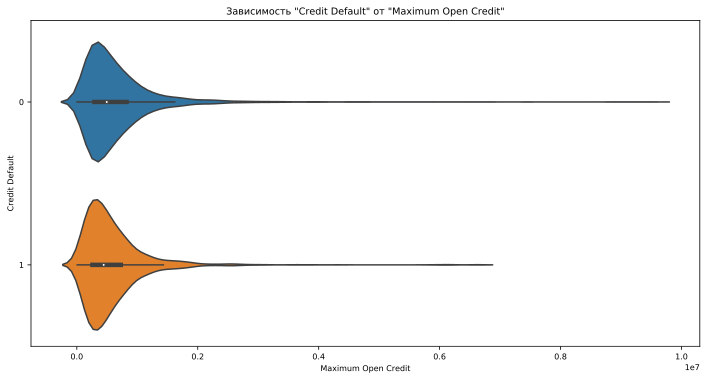

In [53]:
plot_violin_num(df_train_prep_01,'Maximum Open Credit','Credit Default')

#### 7. Проверка, корректировка "Number of Credit Problems"

In [54]:
df_train_prep_01['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [55]:
df_test['Number of Credit Problems'].value_counts()

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
15.0       1
4.0        1
7.0        1
Name: Number of Credit Problems, dtype: int64

Данный признак переводить в категориальный не считаю правильным. Аномалий также нет.

#### 8. Проверка, корректировка "Months since last delinquent"

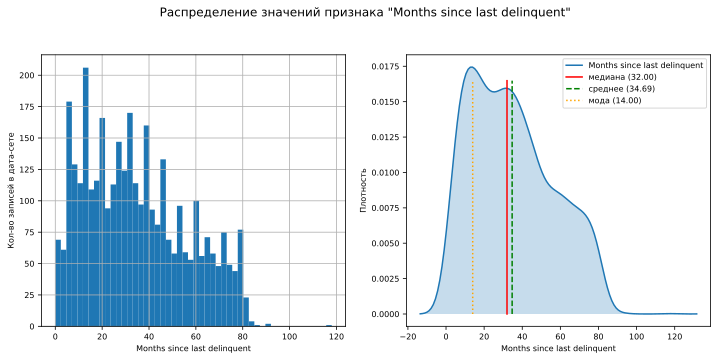

In [56]:
plot_hist_n_kde(df_train_prep_01['Months since last delinquent'], 'Months since last delinquent', mmm='111')

In [57]:
df_train_prep_01['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

Аномальных значений не наблюдаю. Единственное, очень много пропущенных значений. Заменю на моду.

Но, возможно, правильнее будет вообще не учитывать данный столбец при построении модели классификации.

In [58]:
df_train_prep_01.loc[df_train_prep_01['Months since last delinquent'].isnull(),'Months since last delinquent'] = df_train_prep_01['Months since last delinquent'].mode()[0]

#### 9. Проверка, корректировка "Bankruptcies"

In [59]:
df_train_prep_01['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [60]:
df_test['Bankruptcies'].value_counts()

0.0    2252
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [61]:
df_train_prep_01['Bankruptcies'].count()

7486

Данный признак не следует переводить в разряд категориальных. Аномалий также нет. Для устранения пропусков использую моду:

In [62]:
df_train_prep_01['Bankruptcies'].fillna(0, inplace=True)

#### 10. Проверка, корректировка "Current Credit Balance"

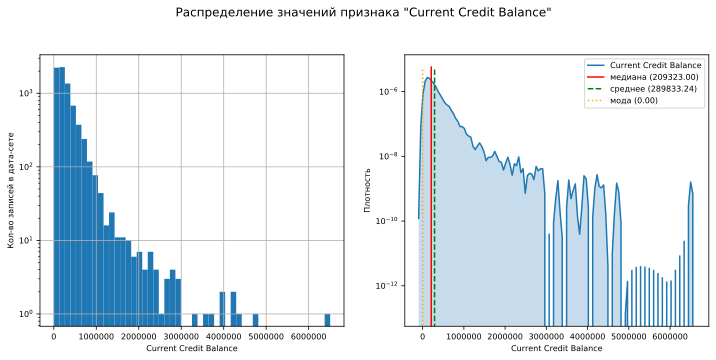

In [63]:
plot_hist_n_kde(df_train_prep_01['Current Credit Balance'], 'Current Credit Balance', y_log=True, mmm='111')

In [64]:
df_train_prep_01['Current Credit Balance'].value_counts().sort_index().head(20)

0.0       53
19.0       3
57.0       2
76.0       2
95.0       1
114.0      1
171.0      1
361.0      2
456.0      1
494.0      1
760.0      1
817.0      1
912.0      1
1102.0     1
1235.0     1
1368.0     2
1425.0     1
1444.0     1
1463.0     1
1482.0     1
Name: Current Credit Balance, dtype: int64

In [65]:
df_train_prep_01['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

Не считаю нулевые значения кредитного баланса выбросами (насколько понимаю этот термин). Максимальные значения также не сильно большие. Оставляю все как есть.

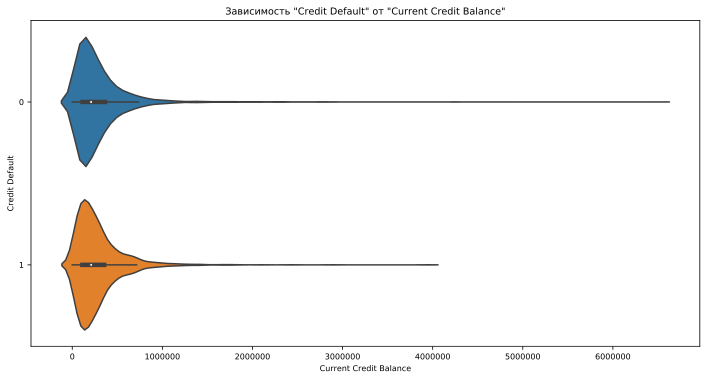

In [66]:
plot_violin_num(df_train_prep_01,'Current Credit Balance','Credit Default')

#### 11. Проверка, корректировка "Monthly Debt"

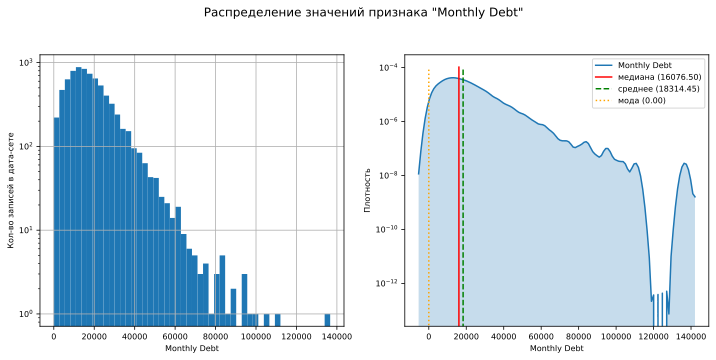

In [67]:
plot_hist_n_kde(df_train_prep_01['Monthly Debt'], 'Monthly Debt', y_log=True, mmm='111')

In [68]:
df_train_prep_01['Monthly Debt'].describe()

count      7500.000000
mean      18314.454133
std       11926.764673
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

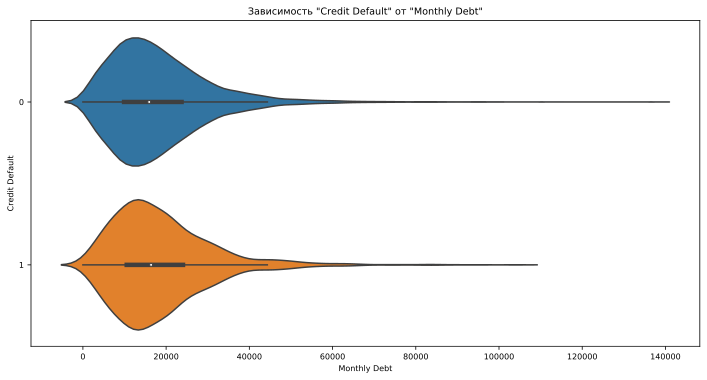

In [69]:
plot_violin_num(df_train_prep_01,'Monthly Debt','Credit Default')

Аномальных значений не наблюдается.

#### 12. Проверка, корректировка "Credit Score"

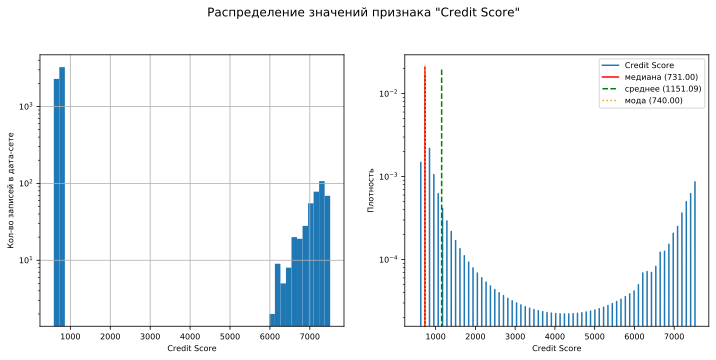

In [70]:
plot_hist_n_kde(df_train_prep_01['Credit Score'], 'Credit Score', y_log=True, mmm='111')

In [71]:
df_train_prep_01['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

Количество аномально высоких значений (больше 1000):

In [72]:
df_train_prep_01.loc[df_train_prep_01['Credit Score']>1000,'Credit Score'].count()

400

Насколько я понимаю, значения кредитного рейтинга физлица должны лежать в диапазоне от 0 до 1000. Посмотрим на зависимость кредитного рейтинга от флага дефолта:

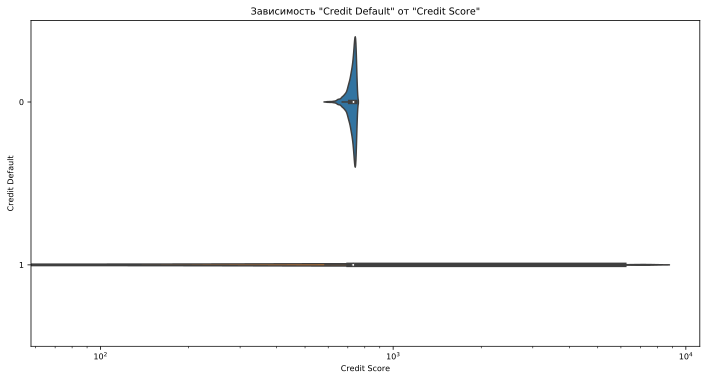

In [73]:
plot_violin_num(df_train_prep_01,'Credit Score','Credit Default',x_log=True)

Похоже, мое предположение верно.

Все пропуски можно заменить:
* при 'Credit Score' равном 0, на медиану;
* при 'Credit Score' равном 1, на 500 (условно плохой кредитный рейтинг);

Аномально большие значения можно заменить на:
* условно плохой рейтинг (те же 500), т.к., судя по графику, аномальные значения присутствуют только в дефолтных записях;
* исходные, деленные на 10 (исходя из предположения, что аномальные значения - это ошибки ввода с лишним нулем на конце). Попробуем этот вариант.

In [74]:
fill_credit_score_nan_n_anomalies_2(df_train_prep_01,500)

Проверим:

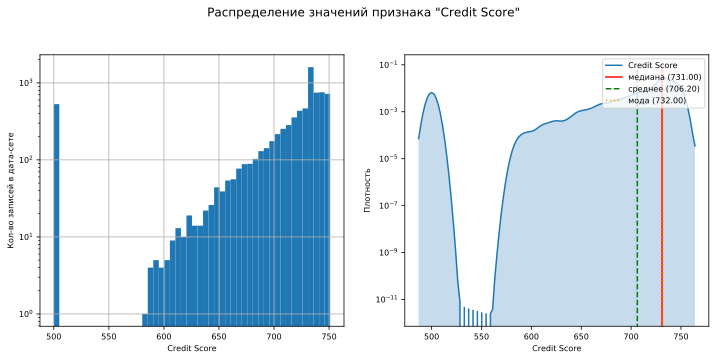

In [75]:
plot_hist_n_kde(df_train_prep_01['Credit Score'], 'Credit Score', y_log=True, mmm='111')

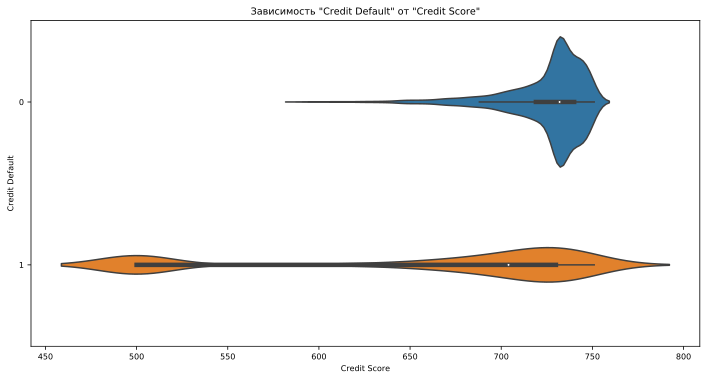

In [76]:
plot_violin_num(df_train_prep_01,'Credit Score','Credit Default')

Подменное значение (500) можно будет варьировать в различных вариантах обучения модели.

#### 13. Проверка, корректировка "Credit Default"

In [77]:
df_train_prep_01['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Со значениями целевого признака порядок.

### *Преобразование к типу int числовых переменных*

Там, где это возможно:

In [78]:
df_train_prep_01.select_dtypes(exclude=np.object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float64
 1   Tax Liens                     7500 non-null   float64
 2   Number of Open Accounts       7500 non-null   float64
 3   Years of Credit History       7500 non-null   float64
 4   Maximum Open Credit           7500 non-null   float64
 5   Number of Credit Problems     7500 non-null   float64
 6   Months since last delinquent  7500 non-null   float64
 7   Bankruptcies                  7500 non-null   float64
 8   Current Loan Amount           7500 non-null   float64
 9   Current Credit Balance        7500 non-null   float64
 10  Monthly Debt                  7500 non-null   float64
 11  Credit Score                  7500 non-null   float64
 12  Credit Default                7500 non-null   int64  
dtypes: 

In [79]:
df_train_prep_01.select_dtypes(exclude=np.object)

Annual Income  Tax Liens  Number of Open Accounts  \
0          482087.0        0.0                     11.0   
1         1025487.0        0.0                     15.0   
2          751412.0        0.0                     11.0   
3          805068.0        0.0                      8.0   
4          776264.0        0.0                     13.0   
...             ...        ...                      ...   
7495       402192.0        0.0                      3.0   
7496      1533984.0        0.0                     10.0   
7497      1878910.0        0.0                     12.0   
7498      1165878.0        0.0                     21.0   
7499      1165878.0        0.0                      8.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                        26.3             685960.0                        1.0   
1                        15.3            1181730.0                        0.0   
2                        35.0            1182434.0                        0.0   
3                        22.5             147400.0                        1.0   
4                        13.6             385836.0                        1.0   
...                       ...                  ...                        ...   
7495                      8.5             107866.0                        0.0   
7496                     26.5             686312.0                        0.0   
7497                     32.1            1778920.0                        0.0   
7498                     26.5            1141250.0                        0.0   
7499                      9.4             480832.0                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
0                             14.0           1.0             265826.0   
1                             14.0           0.0             264968.0   
2                             14.0           0.0             265826.0   
3                             14.0           1.0             121396.0   
4                             14.0           0.0             125840.0   
...                            ...           ...                  ...   
7495                          14.0           0.0             129360.0   
7496                          43.0           0.0             444048.0   
7497                          14.0           0.0             265826.0   
7498                          14.0           0.0             615274.0   
7499                          14.0           0.0              26928.0   

      Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                    47386.0        7914.0         749.0               0  
1                   394972.0       18373.0         737.0               1  
2                   308389.0       13651.0         742.0               0  
3                    95855.0       11338.0         694.0               0  
4                    93309.0        7180.0         719.0               0  
...                      ...           ...           ...             ...  
7495                 73492.0        1900.0         697.0               0  
7496                456399.0       12783.0         741.0               1  
7497                477812.0       12479.0         748.0               0  
7498                476064.0       37118.0         732.0               0  
7499                288192.0        9061.0         732.0               0  

[7500 rows x 13 columns]

In [80]:
columns = df_train_prep_01.select_dtypes(exclude=np.object).columns.tolist()

In [81]:
columns.remove('Years of Credit History')

In [82]:
columns

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [83]:
df_train_prep_01[columns] = df_train_prep_01[columns].astype(int)

Проверка:

In [84]:
df_train_prep_01.select_dtypes(exclude=np.object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   int64  
 1   Tax Liens                     7500 non-null   int64  
 2   Number of Open Accounts       7500 non-null   int64  
 3   Years of Credit History       7500 non-null   float64
 4   Maximum Open Credit           7500 non-null   int64  
 5   Number of Credit Problems     7500 non-null   int64  
 6   Months since last delinquent  7500 non-null   int64  
 7   Bankruptcies                  7500 non-null   int64  
 8   Current Loan Amount           7500 non-null   int64  
 9   Current Credit Balance        7500 non-null   int64  
 10  Monthly Debt                  7500 non-null   int64  
 11  Credit Score                  7500 non-null   int64  
 12  Credit Default                7500 non-null   int64  
dtypes: 

### *Обзор категориальных переменных*

In [85]:
df_train_prep_01.select_dtypes(include=np.object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Home Ownership        7500 non-null   object
 1   Years in current job  7129 non-null   object
 2   Purpose               7500 non-null   object
 3   Term                  7500 non-null   object
dtypes: object(4)
memory usage: 234.5+ KB


In [86]:
for column in df_train_prep_01.select_dtypes(include=['object']).columns:
    print('\n' + '*'*100)
    print(f'\n\t"{column}":')
    print(f'\nТренировочный:\n\n{df_train_prep_01[column].value_counts()}')
    print(f'\nТестовый:\n\n{df_test[column].value_counts()}')


****************************************************************************************************

	"Home Ownership":

Тренировочный:

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Тестовый:

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64

****************************************************************************************************

	"Years in current job":

Тренировочный:

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Тестовый:

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in curre

Аномальных значений в категориальных переменных не наблюдаю. Единственное:
* В "Years in current job" (тренировочные данные) необходимо заполнить пропуски.
* В "Purpose", в тестовом дата-сете, отсутствует значение "renewable energy". В тестовом, при разбиении на бинарные признаки, необходимо будет добавить эту категорию.
* В "Term" строковые значения меняю на числовые - 0 и 1. 

#### 1. Корректировка "Years in current job"

Пропусков не очень много, заполню модой:

In [87]:
df_train_prep_01['Years in current job'].fillna('10+ years',inplace=True)

#### 2. Корректировка "Term"

In [88]:
df_train_prep_01['Term'] = df_train_prep_01['Term'].map({'Short Term': 0, 'Long Term': 1})

Проверка:

In [89]:
df_train_prep_01['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

### *Добавление признака Id*

In [90]:
df_train_prep_01['Id'] = df_train_prep_01.index.tolist()

### *Анализ категориальных переменных в разрезе целевого признака*

#### 1. Анализ "Home Ownership"

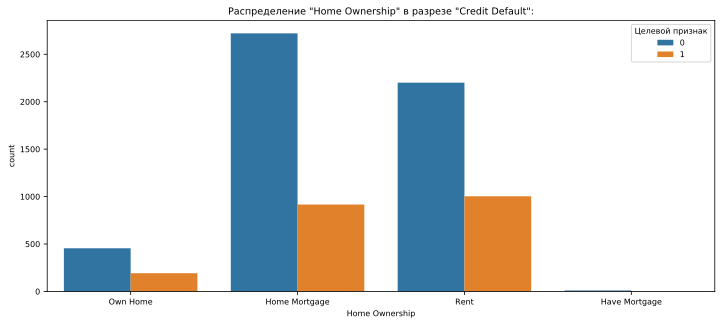

In [91]:
plot_category_distribution_by_target(df_train_prep_01,'Home Ownership')

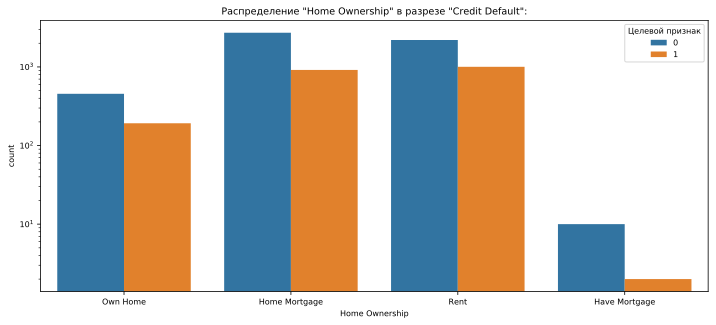

In [92]:
# В логарифмичесокм масштабе:
plot_category_distribution_by_target(df_train_prep_01,'Home Ownership',y_log=True)

**Наблюдение**

По графику видно, что все категории имеют схожее распределение. Если это действительно так, то схожие категории можно заменить одной.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Проверим нашу гипотезу:

In [93]:
chi2_mean_all_to_all(df_train_prep_01,'Home Ownership',30,500)


"Own Home" --- "Home Mortgage":
	Среднее хи-квадрат: 1.898007613936085 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"Own Home" --- "Rent":
	Среднее хи-квадрат: 0.8576007501531591 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"Own Home" --- "Have Mortgage":
	Среднее хи-квадрат: 0.8455205263813493 
	Кол-во ненулевых сэмплов: 25 из 30
	Мощность сэмпла: 500

"Home Mortgage" --- "Rent":
	Среднее хи-квадрат: 3.3748618769567518 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"Home Mortgage" --- "Have Mortgage":
	Среднее хи-квадрат: 0.2849351577358529 
	Кол-во ненулевых сэмплов: 11 из 30
	Мощность сэмпла: 500

"Rent" --- "Have Mortgage":
	Среднее хи-квадрат: 0.12859956070509107 
	Кол-во ненулевых сэмплов: 12 из 30
	Мощность сэмпла: 500


С уверенностью можно сказать, что категории 'Own Home', 'Home Mortgage' и 'Rent' согласованы. Относительно 'Have Mortgage' уверенности в этом нет ввиду малого кол-ва значений.

#### 2. Анализ "Years in current job"

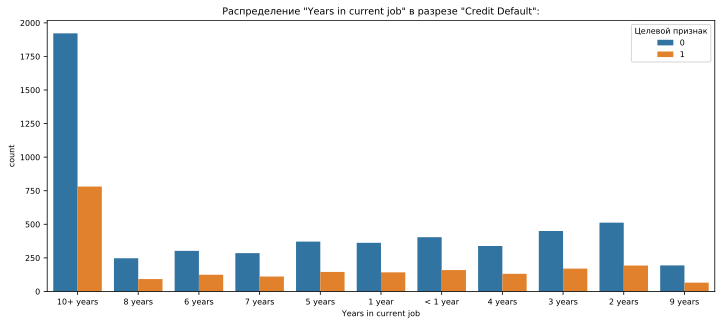

In [94]:
plot_category_distribution_by_target(df_train_prep_01,'Years in current job')

Здесь будет тоже самое? Все согласованы?

In [95]:
chi2_mean_all_to_all(df_train_prep_01,'Years in current job',30,500)


"10+ years" --- "8 years":
	Среднее хи-квадрат: 1.17856899632746 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"10+ years" --- "6 years":
	Среднее хи-квадрат: 0.7085263520411473 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"10+ years" --- "7 years":
	Среднее хи-квадрат: 1.1951920879672098 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"10+ years" --- "5 years":
	Среднее хи-квадрат: 1.272655246799015 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"10+ years" --- "1 year":
	Среднее хи-квадрат: 1.1295221511799272 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"10+ years" --- "< 1 year":
	Среднее хи-квадрат: 0.7527435236698161 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"10+ years" --- "4 years":
	Среднее хи-квадрат: 0.9456540817556465 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"10+ years" --- "3 years":
	Среднее хи-квадрат: 0.733452620438859 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность 

#### 3. Анализ "Purpose"

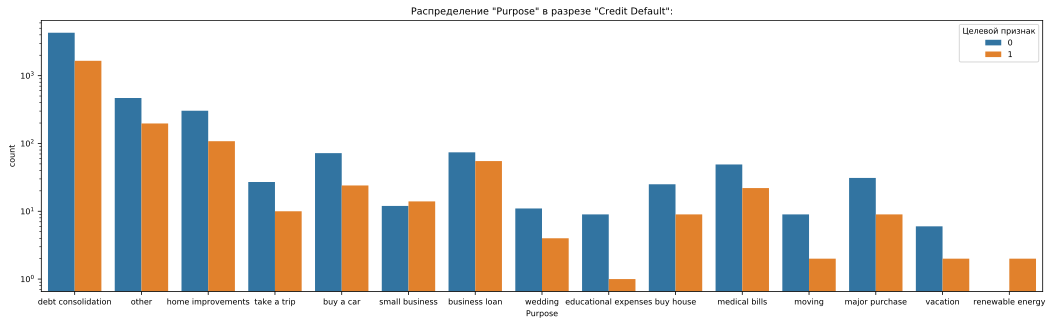

In [96]:
plot_category_distribution_by_target(df_train_prep_01,'Purpose',y_log=True,wide_plot=True)

In [97]:
chi2_mean_all_to_all(df_train_prep_01,'Purpose',30,500)


"debt consolidation" --- "other":
	Среднее хи-квадрат: 0.7091583250606616 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"debt consolidation" --- "home improvements":
	Среднее хи-квадрат: 0.8039475939410556 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"debt consolidation" --- "take a trip":
	Среднее хи-квадрат: 0.7864996635045433 
	Кол-во ненулевых сэмплов: 19 из 30
	Мощность сэмпла: 500

"debt consolidation" --- "buy a car":
	Среднее хи-квадрат: 0.8122135299532575 
	Кол-во ненулевых сэмплов: 26 из 30
	Мощность сэмпла: 500

"debt consolidation" --- "small business":
	Среднее хи-квадрат: 1.1373833771545574 
	Кол-во ненулевых сэмплов: 16 из 30
	Мощность сэмпла: 500

"debt consolidation" --- "business loan":
	Среднее хи-квадрат: 3.7700500818160276 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 500

"debt consolidation" --- "wedding":
	Среднее хи-квадрат: 0.04884839013169439 
	Кол-во ненулевых сэмплов: 11 из 30
	Мощность сэмпла: 500

"debt consolidation

	Среднее хи-квадрат: 2.853189644493994 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 41

"small business" --- "educational expenses":
	Среднее хи-квадрат: 5.712527472527473 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 36

"small business" --- "buy house":
	Среднее хи-квадрат: 4.670895566036235 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 60

"small business" --- "medical bills":
	Среднее хи-квадрат: 4.2612067247255405 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 97

"small business" --- "moving":
	Среднее хи-квадрат: 4.00586913086913 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 37

"small business" --- "major purchase":
	Среднее хи-квадрат: 6.819452438360428 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 66

"small business" --- "vacation":
	Среднее хи-квадрат: 2.0432692307692317 
	Кол-во ненулевых сэмплов: 30 из 30
	Мощность сэмпла: 34

"small business" --- "renewable energy":
	Среднее хи-квадрат: None 
	Кол-во ненулевых сэмплов

### *Анализ количественных переменных в разрезе целевого признака*

Каждый из количественных признаков будем разбивать на две группы по целевой переменной и проверять нижеописанную гипотезу. Опровержение гипотезы будет говорить о том, что группы имеют различное распределение и что исследуемый признак будет полезен при построении модели.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

#### 1. Анализ "Annual Income"

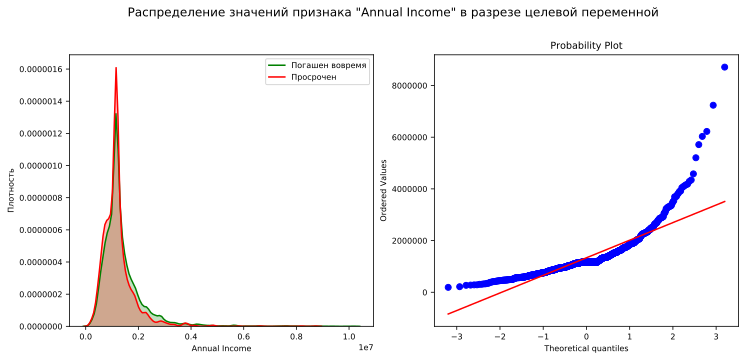

In [98]:
plot_kde_n_qq(df_train_prep_01,'Annual Income')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Annual Income' по целевой переменной, имеют очень похожее распределение. Проверим это.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка (исходные выборки и нормализованные):

In [99]:
shapiro_mean(df_train_prep_01['Annual Income'],10,1000)

Среднее p-value (original): 1.7757750407765762e-33
Среднее p-value (boxcox)  : 6.363390047639701e-11
Среднее p-value (log)     : 8.68648989463284e-12
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Распределение не нормальное. Критерий Стьюдента не применим. Используем критерий Манна-Уитни:

In [100]:
mannwhitney_mean(df_train_prep_01,'Annual Income',10,1000)

Среднее p-value: 0.019836947781570625
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Нулевая гипотеза опровергается - выборки имеют разное распределение. Признак 'Annual Income' будет полезен для построения модели.

Проверим на доверительных интервалах:

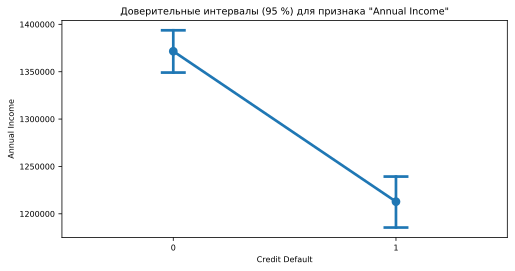

In [101]:
plot_confidence_interval_by_target(df_train_prep_01,'Annual Income')

Доверительные интервалы не пересекаются.

**Вывод:** 'Annual Income' полезен для построения модели.

#### 2. Анализ "Number of Open Accounts"

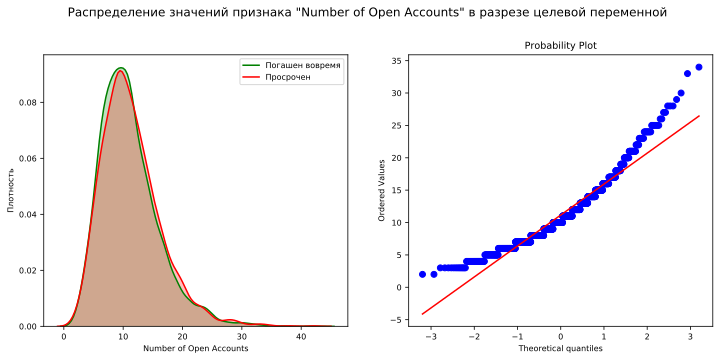

In [102]:
plot_kde_n_qq(df_train_prep_01,'Number of Open Accounts')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Number of Open Accounts' по целевой переменной, имеют очень похожее распределение. Это, возможно, говорит о том, что данный признак будет не очень полезен при построении модели.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка:

In [103]:
shapiro_mean(df_train_prep_01['Number of Open Accounts'],10,1000)

Среднее p-value (original): 2.0342556617311767e-18
Среднее p-value (boxcox)  : 0.00018782257802740787
Среднее p-value (log)     : 5.553123054349852e-07
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Как и предполагалось, критерий Стьюдента не применим. Используем критерий Манна-Уитни:

In [104]:
mannwhitney_mean(df_train_prep_01,'Number of Open Accounts',10,1000)

Среднее p-value: 0.11635268220973001
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Нулевая гипотеза не опровергнута - выборки имеют схожее распределение.

Построим доверительные интервалы:

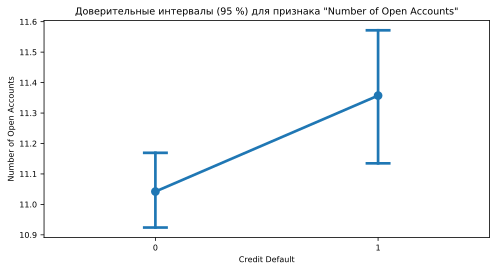

In [105]:
plot_confidence_interval_by_target(df_train_prep_01,'Number of Open Accounts')

Доверительные интервалы пересекаются, что подтверждает критерий Манна-Уитни.

**Вывод:** 'Number of Open Accounts' не сильно полезен для построения модели.

#### 3. Анализ "Years of Credit History"

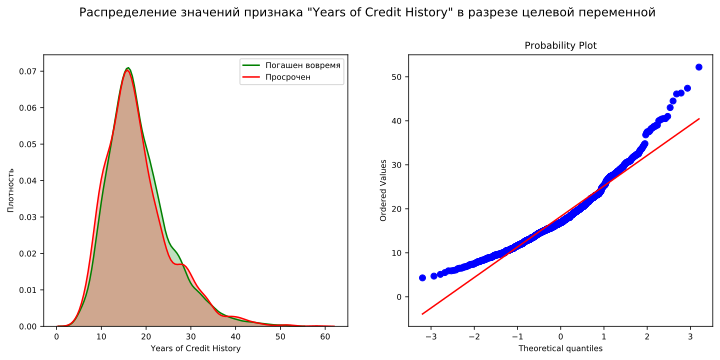

In [106]:
plot_kde_n_qq(df_train_prep_01,'Years of Credit History')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Years of Credit History' по целевой переменной, имеют очень похожее распределение. Это, возможно, говорит о том, что данный признак будет не очень полезен при построении модели.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка:

In [107]:
shapiro_mean(df_train_prep_01['Years of Credit History'],10,1000)

Среднее p-value (original): 1.349424210109421e-16
Среднее p-value (boxcox)  : 0.16295234197750688
Среднее p-value (log)     : 0.07489810107872472
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Преобразование Box-Cox дает неплохой результат.

Нормализуем всю выборку:

In [108]:
box_cox, maxlog = boxcox(df_train_prep_01['Years of Credit History'])

In [109]:
df_boxcox = pd.DataFrame(box_cox,columns=['Years of Credit History --- boxcox'])

Посмотрим на Q-Q диаграмму:

<Figure size 576x288 with 0 Axes>

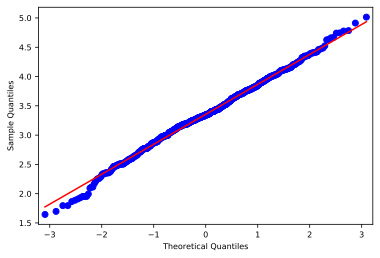

In [110]:
plot_q_q(df_boxcox['Years of Credit History --- boxcox'])

Добавим новый признак - нормализованный 'Years of Credit History' - в дата-сет и проверим на схожесть распределений групп в разрезе целевого признака.

In [111]:
df_train_prep_01 = pd.concat([df_train_prep_01,df_boxcox],axis=1)

In [112]:
df_train_prep_01.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home         482087            10+ years          0   
1       Own Home        1025487            10+ years          0   
2  Home Mortgage         751412              8 years          0   
3       Own Home         805068              6 years          0   
4           Rent         776264              8 years          0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                       11                     26.3               685960   
1                       15                     15.3              1181730   
2                       11                     35.0              1182434   
3                        8                     22.5               147400   
4                       13                     13.6               385836   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                          1                            14             1   
1                          0                            14             0   
2                          0                            14             0   
3                          1                            14             1   
4                          1                            14             0   

              Purpose  Term  Current Loan Amount  Current Credit Balance  \
0  debt consolidation     0               265826                   47386   
1  debt consolidation     1               264968                  394972   
2  debt consolidation     0               265826                  308389   
3  debt consolidation     0               121396                   95855   
4  debt consolidation     0               125840                   93309   

   Monthly Debt  Credit Score  Credit Default  Id  \
0          7914           749               0   0   
1         18373           737               1   1   
2         13651           742               0   2   
3         11338           694               0   3   
4          7180           719               0   4   

   Years of Credit History --- boxcox  
0                            3.987227  
1                            3.216280  
2                            4.414165  
3                            3.760079  
4                            3.055059

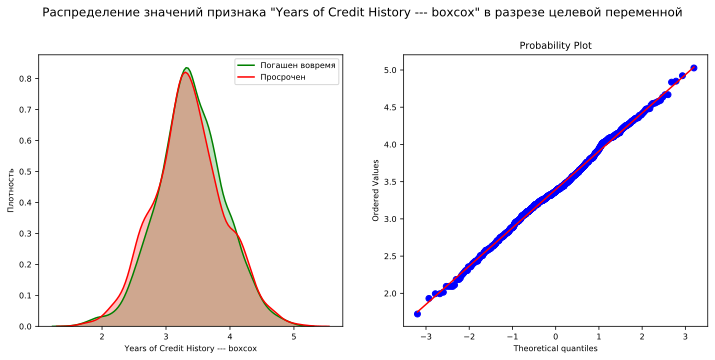

In [113]:
plot_kde_n_qq(df_train_prep_01,'Years of Credit History --- boxcox')

Используем критерий Стьюдента для проверки равенства средних значений выборок:

In [114]:
ttest_ind(df_train_prep_01[df_train_prep_01['Credit Default']==0]['Years of Credit History --- boxcox'],df_train_prep_01[df_train_prep_01['Credit Default']==1]['Years of Credit History --- boxcox'])

Ttest_indResult(statistic=2.427437371893403, pvalue=0.015229302752079643)

In [115]:
t_test_mean(df_train_prep_01,'Years of Credit History --- boxcox',10,1000)

Среднее p-value: 0.3506684135647511
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


??? Какому значению критерия Стьюдента верить - среднему? Или на полных выборках?

Проверю на доверительных интервалах:

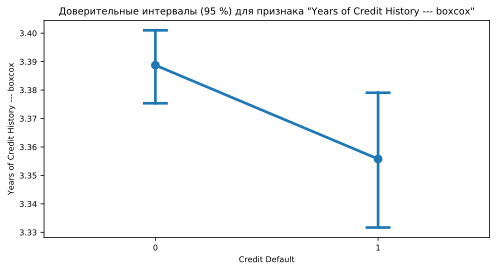

In [116]:
plot_confidence_interval_by_target(df_train_prep_01,'Years of Credit History --- boxcox')

Доверительные интервалы пересекаются.

**Вывод:** 'Years of Credit History --- boxcox' возможно не сильно полезен для построения модели.

#### 4. Анализ "Current Loan Amount"

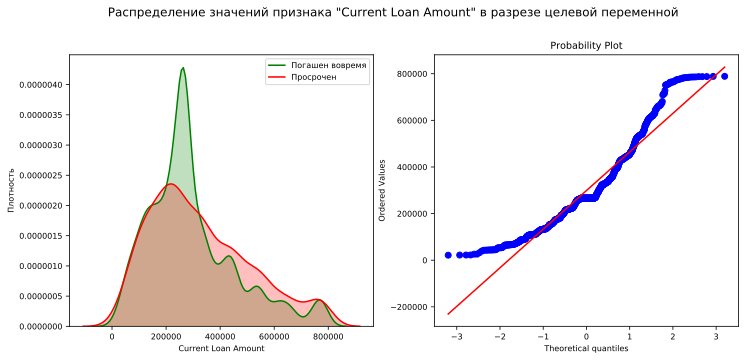

In [117]:
plot_kde_n_qq(df_train_prep_01,'Current Loan Amount')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Current Loan Amount' по целевой переменной, имеют разное распределение. Это, возможно, говорит о том, что данный признак будет полезен при построении модели.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка:

In [118]:
shapiro_mean(df_train_prep_01['Current Loan Amount'],10,1000)

Среднее p-value (original): 6.034982235185815e-20
Среднее p-value (boxcox)  : 5.941339161097403e-07
Среднее p-value (log)     : 1.7178348171321243e-13
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Как и предполагалось, критерий Стьюдента не применим. Используем критерий Манна-Уитни:

In [119]:
mannwhitney_mean(df_train_prep_01,'Current Loan Amount',10,1000)

Среднее p-value: 0.08306232716169885
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Нулевая гипотеза опровергнута.

Посмотрим на доверительные интервалы:

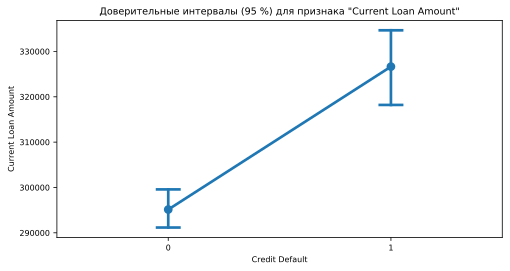

In [120]:
plot_confidence_interval_by_target(df_train_prep_01,'Current Loan Amount')

Доверительные интервалы не пересекаются.

**Вывод:** 'Current Loan Amount' полезен для построения модели.

#### 5. Анализ "Maximum Open Credit"

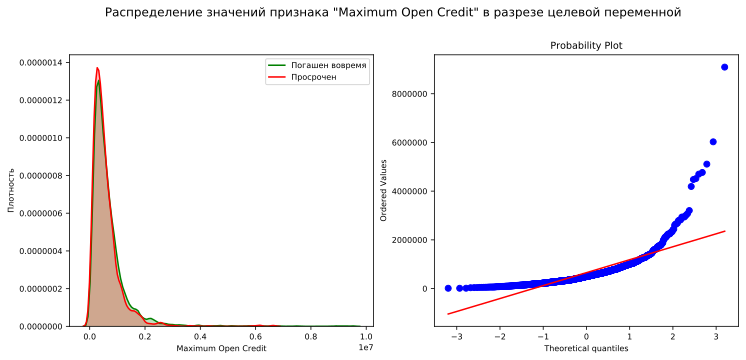

In [121]:
plot_kde_n_qq(df_train_prep_01,'Maximum Open Credit')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Maximum Open Credit' по целевой переменной, имеют схожее распределение. Если это так, то признак не будет полезен при построении модели. Проверим.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка:

In [122]:
shapiro_mean(df_train_prep_01['Maximum Open Credit'],10,1000)

Среднее p-value (original): 9.346590501546722e-37
Среднее p-value (boxcox)  : 0.022826959450571848
Среднее p-value (log)     : 0.00025823686365651356
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Как и предполагалось, критерий Стьюдента не применим. Хотя выборка неплохо поддается нормализации. Используем критерий Манна-Уитни:

In [123]:
mannwhitney_mean(df_train_prep_01,'Maximum Open Credit',30,1000)

Среднее p-value: 0.06397528950991113
Кол-во сэмплов: 30, мощность каждого сэмпла: 1000


Строго говоря, нулевая гипотеза не опровергнута, но среднее достигнутое значение p-value близко к пороговому.

Посмотрим на доверительные интервалы:

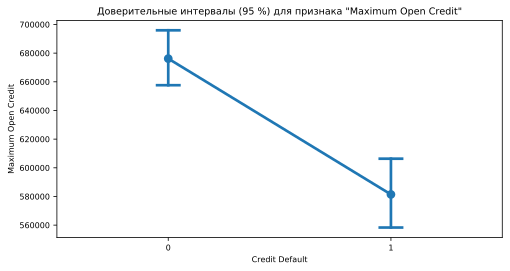

In [124]:
plot_confidence_interval_by_target(df_train_prep_01,'Maximum Open Credit')

Доверительные интервалы не пересекаются.

**Вывод:** 'Maximum Open Credit' может быть полезен для построения модели.

#### 6. Анализ "Months since last delinquent"

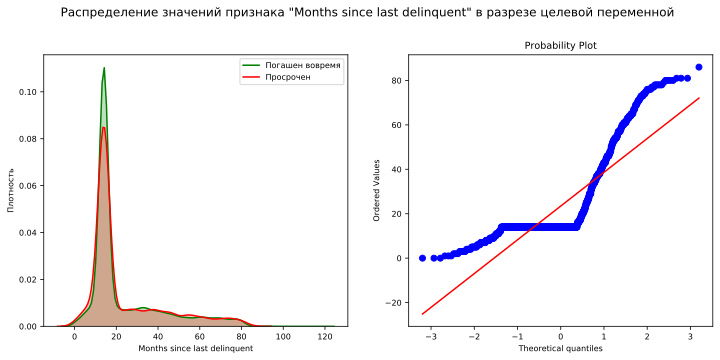

In [125]:
plot_kde_n_qq(df_train_prep_01,'Months since last delinquent')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Months since last delinquent' по целевой переменной, имеют схожее распределение. Если это так, то признак не будет полезен при построении модели. Проверим.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка:

In [126]:
shapiro_mean(df_train_prep_01['Months since last delinquent'],10,1000,bc=False)

Среднее p-value (original): 4.5225343246218204e-38
Среднее p-value (log)     : 0.9
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Преобразование Box-Cox не применимо, т.к. в выборке есть нулевые значения, а логарифмирование дает неплохой результат.

In [127]:
df_tmp_log = np.log(df_train_prep_01['Months since last delinquent'])/np.log(2)

In [128]:
df_tmp_log = pd.DataFrame(df_tmp_log.values,columns=['Months since last delinquent --- log'])

Посмотрим на Q-Q диаграмму:

<Figure size 576x288 with 0 Axes>

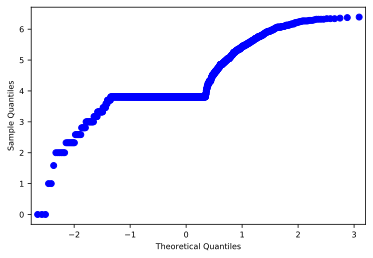

In [129]:
plot_q_q(df_tmp_log['Months since last delinquent --- log'])

Все же распределение далеко от нормального. Используем критерий Манна-Уитни:

In [130]:
mannwhitney_mean(df_train_prep_01,'Months since last delinquent',30,1000)

Среднее p-value: 0.2704530228534267
Кол-во сэмплов: 30, мощность каждого сэмпла: 1000


Нулевая гипотеза не опровергнута. Проверим на доверительных интервалах:

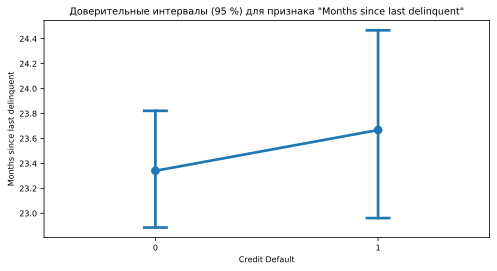

In [131]:
plot_confidence_interval_by_target(df_train_prep_01,'Months since last delinquent')

Доверительные интервалы сильно пересекаются. К тому же данный признак изначально имел очень много пропущенных значений.

**Вывод:** 'Months since last delinquent' не будет полезен для построения модели.

#### 7. Анализ "Current Credit Balance"

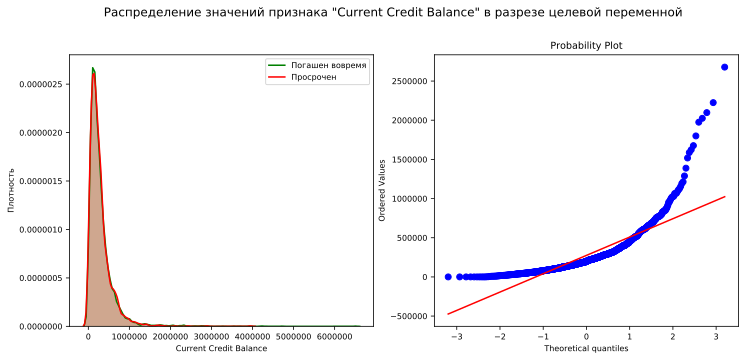

In [132]:
plot_kde_n_qq(df_train_prep_01,'Current Credit Balance')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Current Credit Balance' по целевой переменной, имеют схожее распределение. Признак, вероятно, не будет полезен при построении модели. Проверим.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка:

In [133]:
shapiro_mean(df_train_prep_01['Current Credit Balance'],10,1000,bc=False)

Среднее p-value (original): 7.526255403947618e-38
Среднее p-value (log)     : 1.0
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Преобразование Box-Cox не применимо, т.к. в выборке есть нулевые значения, а логарифмирование дает неплохой результат.

In [134]:
df_tmp_log = np.log(df_train_prep_01['Current Credit Balance'])/np.log(2)

In [135]:
df_tmp_log = pd.DataFrame(df_tmp_log.values,columns=['Current Credit Balance --- log'])

Посмотрим на Q-Q диаграмму:

<Figure size 576x288 with 0 Axes>

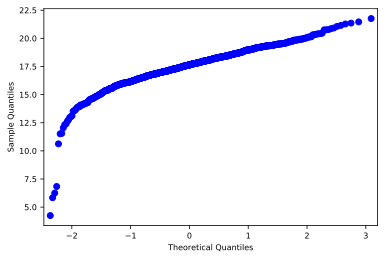

In [136]:
plot_q_q(df_tmp_log['Current Credit Balance --- log'])

Все же распределение далеко от нормального. Используем критерий Манна-Уитни:

In [137]:
mannwhitney_mean(df_train_prep_01,'Current Credit Balance',30,1000)

Среднее p-value: 0.286406658032749
Кол-во сэмплов: 30, мощность каждого сэмпла: 1000


Нулевая гипотеза не опровергнута. Проверим на доверительных интервалах:

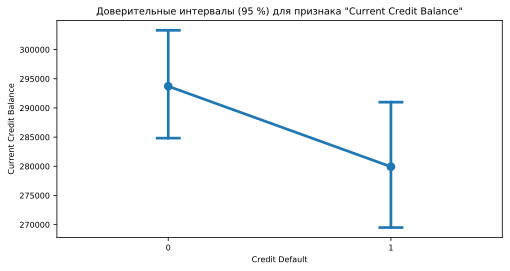

In [138]:
plot_confidence_interval_by_target(df_train_prep_01,'Current Credit Balance')

Доверительные интервалы сильно пересекаются.

**Вывод:** 'Current Credit Balance' не будет полезен для построения модели.

#### 8. Анализ "Monthly Debt"

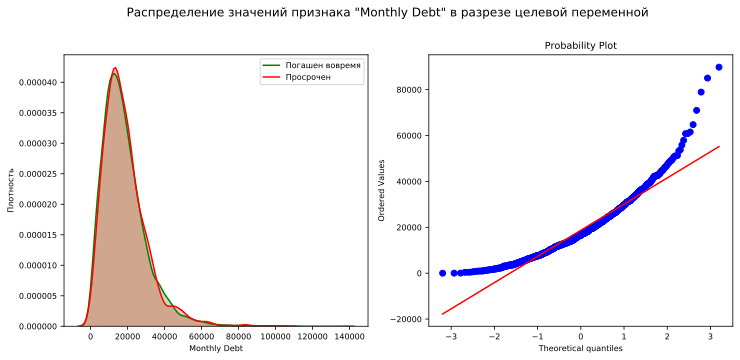

In [139]:
plot_kde_n_qq(df_train_prep_01,'Monthly Debt')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Monthly Debt' по целевой переменной, имеют схожее распределение. Признак, вероятно, не будет полезен при построении модели. Проверим.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка:

In [140]:
shapiro_mean(df_train_prep_01['Monthly Debt'],10,1000,bc=False)

Среднее p-value (original): 2.3927580190745878e-24
Среднее p-value (log)     : 0.5
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Преобразование Box-Cox не применимо, т.к. в выборке есть нулевые значения, логарифмирование также не имеет смысла применять.

Используем критерий Манна-Уитни:

In [141]:
mannwhitney_mean(df_train_prep_01,'Monthly Debt',30,1000)

Среднее p-value: 0.26198141449655277
Кол-во сэмплов: 30, мощность каждого сэмпла: 1000


Нулевая гипотеза не опровергнута. Посмотрим на доверительные интервалы:

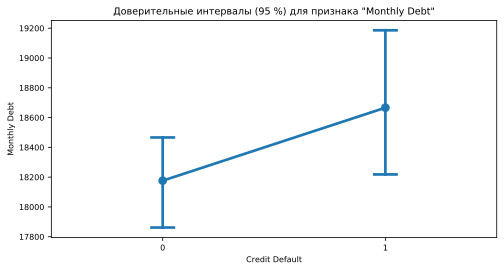

In [142]:
plot_confidence_interval_by_target(df_train_prep_01,'Monthly Debt')

Доверительные интервалы сильно пересекаются.

**Вывод:** 'Monthly Debt' не будет сильно полезен для построения модели.

#### 9. Анализ "Credit Score"

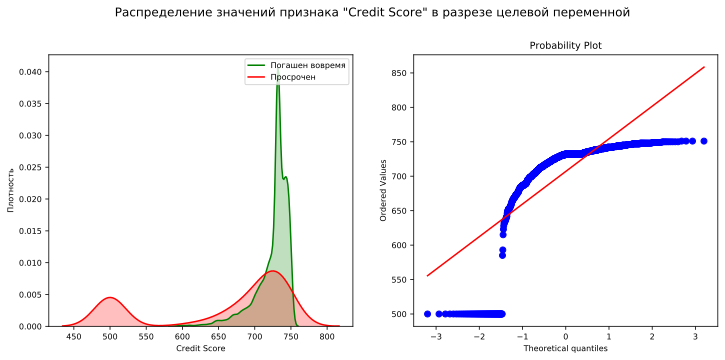

In [143]:
plot_kde_n_qq(df_train_prep_01,'Credit Score')

Судя по графику плотности распределения, группы, полученные в результате разбиения признака 'Credit Score' по целевой переменной, имеют различное распределение. Признак, возможно, будет полезен при построении модели.

Также видно, что распределение значений данного признака далеко от нормального. Критерий Стьюдента не применим.

Проверим на "нормальность" по критерию Шапиро-Уилка:

In [144]:
shapiro_mean(df_train_prep_01['Credit Score'],10,1000)

Среднее p-value (original): 8.089696034547168e-43
Среднее p-value (boxcox)  : 0.3
Среднее p-value (log)     : 2.676480066860401e-44
Кол-во сэмплов: 10, мощность каждого сэмпла: 1000


Преобразование Box-Cox дает неплохой результат.

Нормализуем всю выборку:

In [145]:
box_cox, maxlog = boxcox(df_train_prep_01['Credit Score'])

In [146]:
df_boxcox = pd.DataFrame(box_cox,columns=['Credit Score --- boxcox'])

Посмотрим на Q-Q диаграмму:

<Figure size 576x288 with 0 Axes>

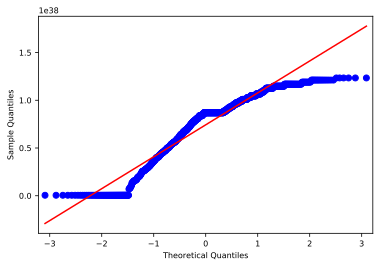

In [147]:
plot_q_q(df_boxcox['Credit Score --- boxcox'])

Судя по диаграмме, выборка не сильно приблизилась к нормально распределенной. Новый признак для дата-сета генерировать не будем.

Для проверки равенства мат. ожиданий групп используем критерий Манна-Уитни:

In [148]:
mannwhitney_mean(df_train_prep_01,'Credit Score',30,1000)

Среднее p-value: 3.793073722065262e-24
Кол-во сэмплов: 30, мощность каждого сэмпла: 1000


Нулевая гипотеза очевидно опровергается.

Посмотрим на доверительные интервалы:

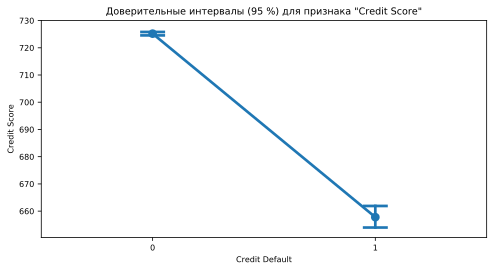

In [149]:
plot_confidence_interval_by_target(df_train_prep_01,'Credit Score')

Доверительные интервалы не пересекаются.

**Вывод:** 'Credit Score' должен быть полезен для построения модели.

**Общий вывод**: точный перечень признаков, которые необходимо использовать при построении модели, можно будет определить после схожего анализа тестового дата-сета. 

### Анализ тестового датасета

In [150]:
df_test_prep_01 = df_test.copy()

### *Анализ количественных переменных*

#### 1. Проверка, корректировка "Annual Income"

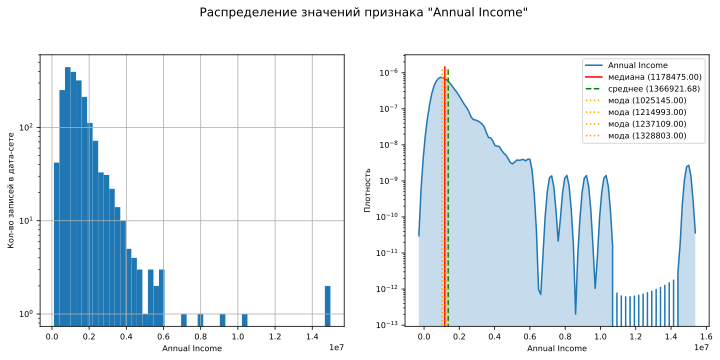

In [151]:
plot_hist_n_kde(df_test_prep_01['Annual Income'], 'Annual Income', y_log=True, mmm='111')

In [152]:
print(f"Минимальное значение: {df_test_prep_01['Annual Income'].min()}")
print(f"Максимальное значение: {df_test_prep_01['Annual Income'].max()}")

Минимальное значение: 106533.0
Максимальное значение: 14975610.0


##### Обработка пропусков:

Кол-во пропущенных значений 'Annual Income' по целям кредита:

In [153]:
df_test_prep_01.loc[df_test_prep_01['Annual Income'].isnull(), 'Purpose'].value_counts()

debt consolidation    405
other                  49
home improvements      33
business loan           7
buy a car               5
medical bills           5
buy house               4
take a trip             3
vacation                1
major purchase          1
Name: Purpose, dtype: int64

Для заполнения пропусков буду брать медианные значения, в зависимости от целей кредита:

In [154]:
fill_annual_income_nan(df_test_prep_01)

Проверка - не осталось ли пропущенных значений:

In [155]:
len(df_test_prep_01.loc[df_test_prep_01['Annual Income'].isnull()])

0

#### 2. Проверка, корректировка "Tax Liens"

При анализе тренировочного дата-сета уже рассматривал данный признак.

#### 3. Проверка, корректировка "Number of Open Accounts"

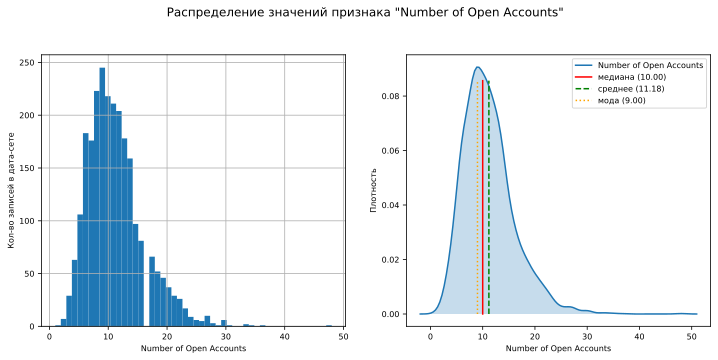

In [156]:
plot_hist_n_kde(df_test_prep_01['Number of Open Accounts'], 'Number of Open Accounts', mmm='111')

In [157]:
df_test_prep_01['Number of Open Accounts'].describe()

count    2500.000000
mean       11.184400
std         4.852774
min         1.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        48.000000
Name: Number of Open Accounts, dtype: float64

Аномалий в значениях данного признака нет.

#### 4. Проверка, корректировка "Years of Credit History"

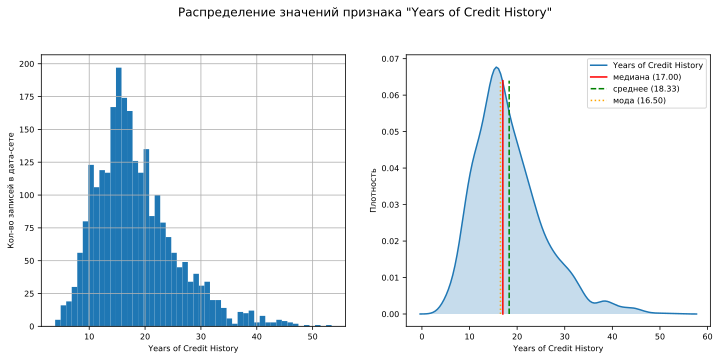

In [158]:
plot_hist_n_kde(df_test_prep_01['Years of Credit History'], 'Years of Credit History', mmm='111')

In [159]:
df_test_prep_01['Years of Credit History'].describe()

count    2500.000000
mean       18.325920
std         7.254659
min         3.900000
25%        13.400000
50%        17.000000
75%        22.100000
max        53.400000
Name: Years of Credit History, dtype: float64

Аномалий не наблюдается.

#### 5. Проверка, корректировка "Current Loan Amount"

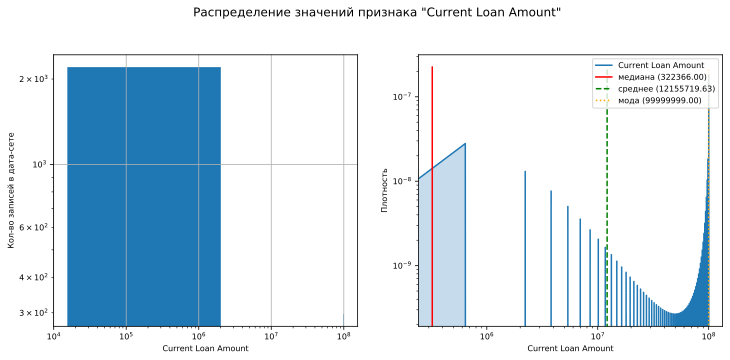

In [160]:
plot_hist_n_kde(df_test_prep_01['Current Loan Amount'], 'Current Loan Amount', x_log=True, y_log=True, mmm='111')

In [161]:
df_test_prep_01['Current Loan Amount'].describe()

count    2.500000e+03
mean     1.215572e+07
std      3.226097e+07
min      1.542200e+04
25%      1.871265e+05
50%      3.223660e+05
75%      5.225825e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [162]:
df_test_prep_01['Current Loan Amount'].value_counts()

99999999.0    297
110462.0        3
396506.0        3
327404.0        3
258676.0        3
             ... 
543290.0        1
105578.0        1
43054.0         1
162448.0        1
450560.0        1
Name: Current Loan Amount, Length: 2026, dtype: int64

Максимальное значение, не считая 99999999:

In [163]:
df_test_prep_01.loc[df_test_prep_01['Current Loan Amount'] < 99999999,'Current Loan Amount'].max()

789096.0

Значения 'Current Loan Amount', равные моде, определенно являются выбросами. Их почти 12% от общего числа значений (также, как и в тренировочном дата-сете). К тому же они на два порядка больше, чем предыдущее максимальное значение.

Заменю эти аномальные значения на медианное, полученное без учета этих выбросов, - как и при обработке тренировочных данных.

Но, как вариант, можно использовать медианные значения, полученные в зависимости от срока кредита, текущего кредитного баланса или годового дохода.

In [164]:
median_normal = df_test_prep_01.loc[df_test_prep_01['Current Loan Amount'] < 99999999,'Current Loan Amount'].median()
median_normal

271260.0

In [165]:
df_test_prep_01.loc[df_test_prep_01['Current Loan Amount'] == 99999999,'Current Loan Amount'] = median_normal

Посмотрим, что получилось:

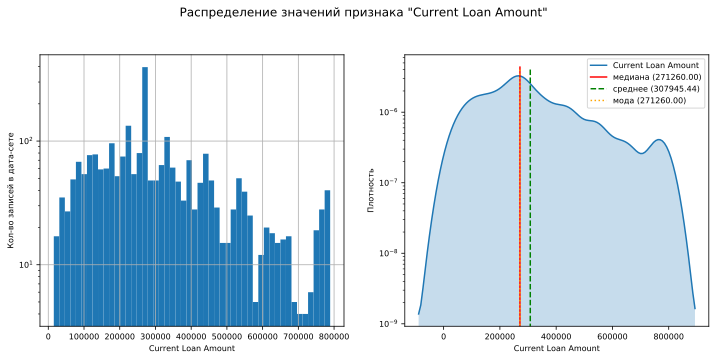

In [166]:
plot_hist_n_kde(df_test_prep_01['Current Loan Amount'], 'Current Loan Amount', y_log=True, mmm='111')

In [167]:
df_test_prep_01['Current Loan Amount'].describe()

count      2500.00000
mean     307945.44000
std      171999.22918
min       15422.00000
25%      187126.50000
50%      271260.00000
75%      398893.00000
max      789096.00000
Name: Current Loan Amount, dtype: float64

#### 6. Проверка, корректировка "Maximum Open Credit"

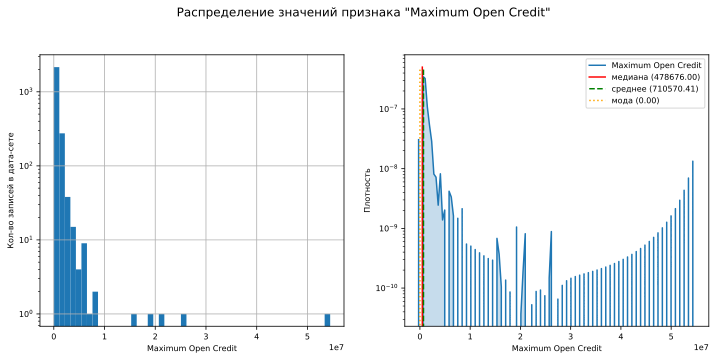

In [168]:
plot_hist_n_kde(df_test_prep_01['Maximum Open Credit'], 'Maximum Open Credit', y_log=True, mmm='111')

In [169]:
df_test_prep_01['Maximum Open Credit'].describe()

count    2.500000e+03
mean     7.105704e+05
std      1.511983e+06
min      0.000000e+00
25%      2.785860e+05
50%      4.786760e+05
75%      8.025985e+05
max      5.448439e+07
Name: Maximum Open Credit, dtype: float64

In [170]:
df_test_prep_01.loc[df_test_prep_01['Maximum Open Credit'] == 0,'Maximum Open Credit'].count()

14

14 записей в датасете имеют значением данного признака 0. Может ли макисмальная сумма взятого кредита равняться нулю? Вряд ли. Посмотрим на текущую задолженность этих заемщиков:

In [171]:
df_test_prep_01.loc[df_test_prep_01['Maximum Open Credit'] == 0,'Current Loan Amount'].describe()

count        14.000000
mean     307215.857143
std      185350.805498
min       15422.000000
25%      202416.500000
50%      273856.000000
75%      460878.000000
max      563376.000000
Name: Current Loan Amount, dtype: float64

Ноль - это явно аномальное значение. Исправлю - сделаю равным текущей сумме кредита:

In [172]:
df_test_prep_01.loc[df_test_prep_01['Maximum Open Credit'] == 0,'Maximum Open Credit'] = df_test_prep_01.loc[df_test_prep_01['Maximum Open Credit'] == 0,'Current Loan Amount']

Также есть аномально высокие значения:

In [173]:
df_test_prep_01.loc[df_test_prep_01['Maximum Open Credit'] > (10**7)]

Home Ownership  Annual Income Years in current job  Tax Liens  \
222   Home Mortgage      2807535.0            10+ years        0.0   
228   Home Mortgage      3356255.0            10+ years        0.0   
584   Home Mortgage      1313413.0              7 years        0.0   
1568  Home Mortgage      1236292.0            10+ years        0.0   
2152  Home Mortgage      1181857.0            10+ years        0.0   

      Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
222                      12.0                     19.3           15568542.0   
228                      20.0                     17.2           54484386.0   
584                      11.0                     21.5           19185386.0   
1568                     18.0                     32.8           26069956.0   
2152                     16.0                     32.3           20842404.0   

      Number of Credit Problems  Months since last delinquent  Bankruptcies  \
222                         0.0                           NaN           0.0   
228                         0.0                           NaN           0.0   
584                         0.0                          40.0           0.0   
1568                        0.0                           NaN           0.0   
2152                        0.0                           NaN           0.0   

                 Purpose        Term  Current Loan Amount  \
222            buy house  Short Term             271260.0   
228    home improvements   Long Term             777238.0   
584                other   Long Term             495660.0   
1568           buy a car  Short Term              65560.0   
2152  debt consolidation  Short Term             612502.0   

      Current Credit Balance  Monthly Debt  Credit Score  
222                3240374.0       27607.0         750.0  
228                5176018.0       42792.0         695.0  
584                2236832.0        6906.0         743.0  
1568                697965.0       23232.0         751.0  
2152               6030087.0       75206.0           NaN

Заменю их на соответствующие значения кредитного баланса:

In [174]:
df_test_prep_01.loc[df_test_prep_01['Maximum Open Credit'] > (10**7),'Maximum Open Credit'] = df_test_prep_01.loc[df_test_prep_01['Maximum Open Credit'] > (10**7),'Current Credit Balance']

Посмотрим, что получилось:

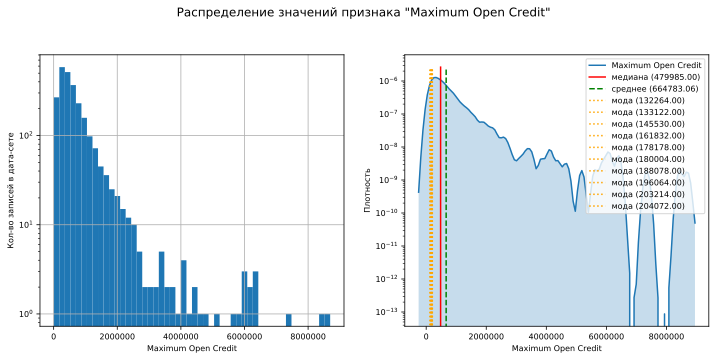

In [175]:
plot_hist_n_kde(df_test_prep_01['Maximum Open Credit'], 'Maximum Open Credit', y_log=True, mmm='111')

In [176]:
df_test_prep_01['Maximum Open Credit'].describe()

count    2.500000e+03
mean     6.647831e+05
std      7.095755e+05
min      4.444000e+03
25%      2.797190e+05
50%      4.799850e+05
75%      8.003710e+05
max      8.693828e+06
Name: Maximum Open Credit, dtype: float64

#### 7. Проверка, корректировка "Number of Credit Problems"

Также рассматривал при обзоре тестового дата-сета. Все здесь хорошо.

#### 8. Проверка, корректировка "Months since last delinquent"

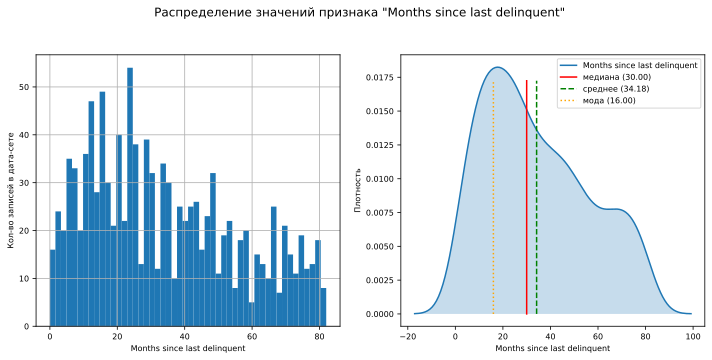

In [177]:
plot_hist_n_kde(df_test_prep_01['Months since last delinquent'], 'Months since last delinquent', mmm='111')

In [178]:
df_test_prep_01['Months since last delinquent'].describe()

count    1142.000000
mean       34.181261
std        22.024277
min         0.000000
25%        16.000000
50%        30.000000
75%        50.000000
max        82.000000
Name: Months since last delinquent, dtype: float64

Аномальных значений не наблюдаю. Но, также, как и в тренировочном, очень много пропущенных значений. Заменю на моду.

Но, возможно, правильнее будет вообще не учитывать данный столбец при построении модели классификации.

In [179]:
df_test_prep_01.loc[df_test_prep_01['Months since last delinquent'].isnull(),'Months since last delinquent'] = df_test_prep_01['Months since last delinquent'].mode()[0]

In [180]:
df_test_prep_01['Months since last delinquent'].describe()

count    2500.000000
mean       24.305200
std        17.422097
min         0.000000
25%        16.000000
50%        16.000000
75%        27.000000
max        82.000000
Name: Months since last delinquent, dtype: float64

#### 9. Проверка, корректировка "Bankruptcies"

In [181]:
df_test_prep_01['Bankruptcies'].value_counts()

0.0    2252
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

In [182]:
df_test_prep_01['Bankruptcies'].count()

2497

Для устранения пропусков использую моду:

In [183]:
df_test_prep_01['Bankruptcies'].fillna(0, inplace=True)

#### 10. Проверка, корректировка "Current Credit Balance"

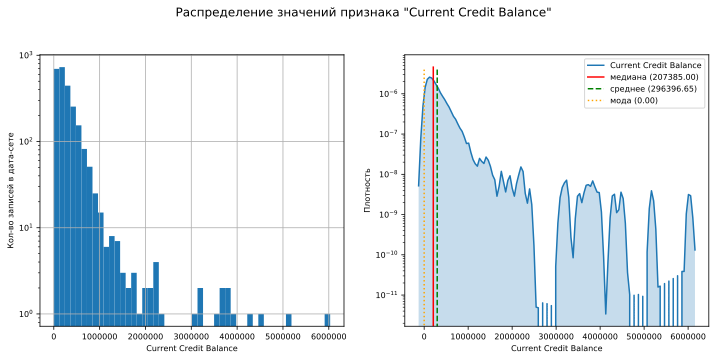

In [184]:
plot_hist_n_kde(df_test_prep_01['Current Credit Balance'], 'Current Credit Balance', y_log=True, mmm='111')

In [185]:
df_test_prep_01['Current Credit Balance'].value_counts().sort_index().head(20)

0.0       11
57.0       1
95.0       1
114.0      1
399.0      1
551.0      1
589.0      1
722.0      1
893.0      1
931.0      1
988.0      1
1197.0     1
1862.0     1
2071.0     1
2109.0     1
2318.0     2
2603.0     1
2983.0     1
3553.0     1
3762.0     1
Name: Current Credit Balance, dtype: int64

In [186]:
df_test_prep_01['Current Credit Balance'].describe()

count    2.500000e+03
mean     2.963966e+05
std      3.783020e+05
min      0.000000e+00
25%      1.101145e+05
50%      2.073850e+05
75%      3.663485e+05
max      6.030087e+06
Name: Current Credit Balance, dtype: float64

Не считаю нулевые значения кредитного баланса выбросами (насколько понимаю этот термин). Максимальные значения также не сильно большие. Оставляю все как есть.

#### 11. Проверка, корректировка "Monthly Debt"

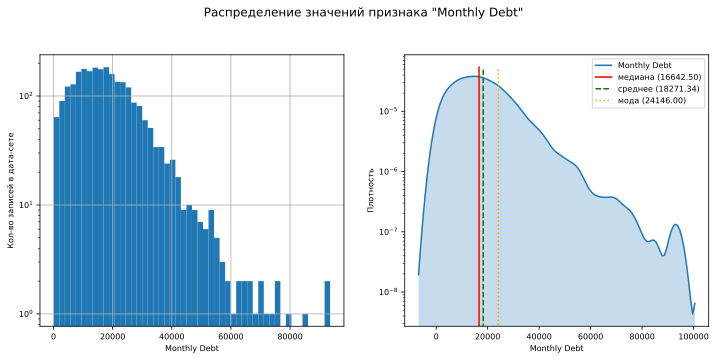

In [187]:
plot_hist_n_kde(df_test_prep_01['Monthly Debt'], 'Monthly Debt', y_log=True, mmm='111')

In [188]:
df_test_prep_01['Monthly Debt'].describe()

count     2500.000000
mean     18271.340000
std      11543.881469
min         93.000000
25%      10024.750000
50%      16642.500000
75%      24146.000000
max      93555.000000
Name: Monthly Debt, dtype: float64

Аномальных значений не наблюдается.

#### 12. Проверка, корректировка "Credit Score"

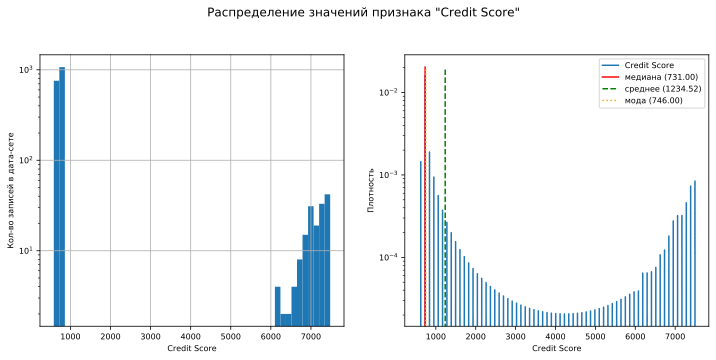

In [189]:
plot_hist_n_kde(df_test_prep_01['Credit Score'], 'Credit Score', y_log=True, mmm='111')

In [190]:
df_test_prep_01['Credit Score'].describe()

count    1987.000000
mean     1234.516860
std      1740.219442
min       585.000000
25%       710.000000
50%       731.000000
75%       743.000000
max      7480.000000
Name: Credit Score, dtype: float64

Количество аномально высоких значений (больше 1000):

In [191]:
df_test_prep_01.loc[df_test_prep_01['Credit Score']>1000,'Credit Score'].count()

160

Выполню ту же процедуру по замене пропусков и выбросов, что и с тренировочным дата-сетом:

In [192]:
fill_credit_score_nan_n_anomalies_2_test_df(df_test_prep_01)

Проверим:

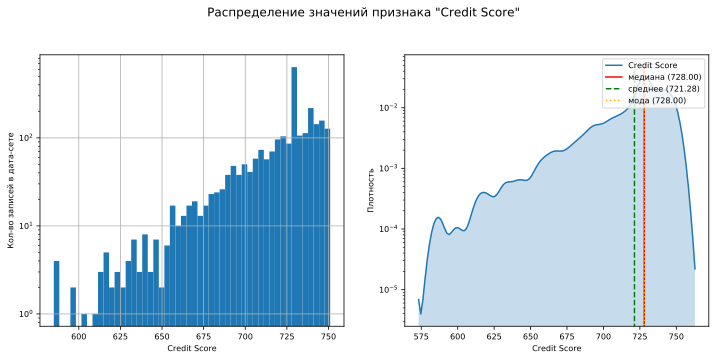

In [193]:
plot_hist_n_kde(df_test_prep_01['Credit Score'], 'Credit Score', y_log=True, mmm='111')

### *Преобразование к типу int числовых переменных*

Там, где это возможно:

In [194]:
df_test_prep_01.select_dtypes(exclude=np.object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   float64
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   float64
 6   Months since last delinquent  2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Current Loan Amount           2500 non-null   float64
 9   Current Credit Balance        2500 non-null   float64
 10  Monthly Debt                  2500 non-null   float64
 11  Credit Score                  2500 non-null   float64
dtypes: float64(12)
memory usage: 234.5 KB


In [195]:
df_test_prep_01.select_dtypes(exclude=np.object)

Annual Income  Tax Liens  Number of Open Accounts  \
0         1181857.0        0.0                      9.0   
1          231838.0        0.0                      6.0   
2         1152540.0        0.0                     10.0   
3         1220313.0        0.0                     16.0   
4         2340952.0        0.0                     11.0   
...             ...        ...                      ...   
2495      1020053.0        0.0                     14.0   
2496      1181857.0        0.0                     15.0   
2497      1171806.0        0.0                     48.0   
2498       723520.0        0.0                     14.0   
2499      1694439.0        0.0                     12.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                        12.5             220968.0                        0.0   
1                        32.7              55946.0                        0.0   
2                        13.7             204600.0                        0.0   
3                        17.0             456302.0                        0.0   
4                        23.6            1207272.0                        0.0   
...                       ...                  ...                        ...   
2495                     29.1             559152.0                        1.0   
2496                     17.0            1737780.0                        0.0   
2497                     12.8            1706430.0                        0.0   
2498                     28.8             945780.0                        0.0   
2499                     18.4            1199748.0                        1.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
0                             70.0           0.0             162470.0   
1                              8.0           0.0              78298.0   
2                             16.0           0.0             200178.0   
3                             70.0           0.0             217382.0   
4                             16.0           0.0             777634.0   
...                            ...           ...                  ...   
2495                          68.0           1.0             271260.0   
2496                          77.0           0.0             468512.0   
2497                          16.0           0.0             430496.0   
2498                          16.0           0.0             257774.0   
2499                          72.0           0.0             763004.0   

      Current Credit Balance  Monthly Debt  Credit Score  
0                   105906.0        6813.0         728.0  
1                    46037.0        2318.0         699.0  
2                   146490.0       18729.0         726.0  
3                   213199.0       27559.0         739.0  
4                   425391.0       42605.0         706.0  
...                      ...           ...           ...  
2495                162735.0       15046.0         745.0  
2496               1439269.0       32996.0         728.0  
2497                676438.0       36912.0         695.0  
2498                391248.0       13506.0         744.0  
2499                559531.0       23440.0         682.0  

[2500 rows x 12 columns]

In [196]:
columns = df_test_prep_01.select_dtypes(exclude=np.object).columns.tolist()

In [197]:
columns.remove('Years of Credit History')

In [198]:
columns

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [199]:
df_test_prep_01[columns] = df_test_prep_01[columns].astype(int)

Проверка:

In [200]:
df_test_prep_01.select_dtypes(exclude=np.object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   int64  
 1   Tax Liens                     2500 non-null   int64  
 2   Number of Open Accounts       2500 non-null   int64  
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   int64  
 5   Number of Credit Problems     2500 non-null   int64  
 6   Months since last delinquent  2500 non-null   int64  
 7   Bankruptcies                  2500 non-null   int64  
 8   Current Loan Amount           2500 non-null   int64  
 9   Current Credit Balance        2500 non-null   int64  
 10  Monthly Debt                  2500 non-null   int64  
 11  Credit Score                  2500 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 234.5 KB


### *Обзор категориальных переменных*

In [201]:
df_test_prep_01.select_dtypes(include=np.object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Home Ownership        2500 non-null   object
 1   Years in current job  2414 non-null   object
 2   Purpose               2500 non-null   object
 3   Term                  2500 non-null   object
dtypes: object(4)
memory usage: 78.2+ KB


Аномальных значений в категориальных переменных нет - анализировал при разборе тренировочного дата-сета. Единственное:
* В "Years in current job" необходимо заполнить пропуски.
* В "Purpose" отсутствует значение "renewable energy". При разбиении на бинарные признаки, необходимо будет добавить эту категорию.
* В "Term" строковые значения меняю на числовые - 0 и 1. 

#### 1. Корректировка "Years in current job"

Пропусков не очень много, заполню модой:

In [202]:
df_test_prep_01['Years in current job'].value_counts()

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

In [203]:
df_test_prep_01['Years in current job'].fillna('10+ years',inplace=True)

#### 2. Корректировка "Term"

In [204]:
df_test_prep_01['Term'] = df_test_prep_01['Term'].map({'Short Term': 0, 'Long Term': 1})

### *Добавление признака Id*

In [205]:
df_test_prep_01['Id'] = df_test_prep_01.index.tolist()

### *Анализ распределений количественных переменных в обоих дата-сетах*

Имеет смысл проводить такой анализ???

Различие распределений значений признака в тренировочном и тестовом дата-сетах будет говорить о том, что этот признак помешает построению правильной модели?

#### 1. Анализ "Annual Income"

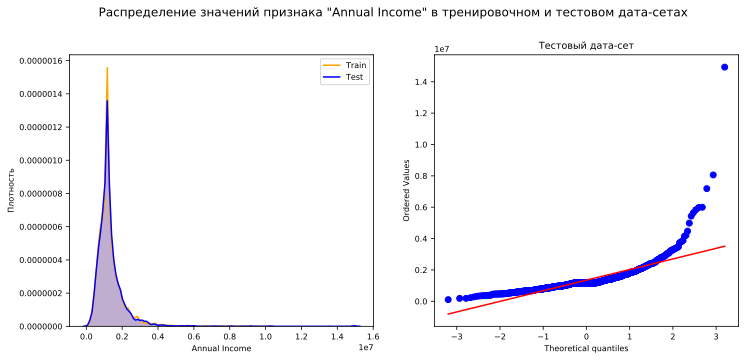

In [206]:
plot_kde_n_qq_tt(df_train_prep_01,df_test_prep_01,'Annual Income')

In [207]:
mannwhitney_mean_t_t(df_train_prep_01,df_test_prep_01,'Annual Income',20,1000)

Среднее p-value: 0.2072822873152175
Кол-во сэмплов: 20, мощность каждого сэмпла: 1000


### *Преобразование категориальных переменных в группы бинарных*

In [ ]:
columns_obj = df_train_prep_01.select_dtypes(include=np.object).columns.to_list()
columns_obj

In [ ]:
df_train_prep_02 = pd.concat([df_train_prep_01,pd.get_dummies(df_train_prep_01,prefix_sep=' --- ',columns=columns_obj)], axis=1)

### Итоговый тренировочный дата-сет

In [ ]:
df_train_prep_02